# 数据导入

In [2]:
from IPython.core.interactiveshell import InteractiveShell #输出所有 的输入项 'all', 'last', 'last_expr' or 'none'
InteractiveShell.ast_node_interactivity = "last_expr"
import numpy as np
import pylab as pl
from numpy import *
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats
import datetime
from matplotlib import *
from pylab import *
import pandas as pd
from pyecharts.chart import Chart
from pyecharts.echarts.option import get_all_options
%matplotlib inline
plt.style.use('ggplot')
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False 
import jieba
import jieba.analyse
jieba.load_userdict('Customized_words.txt')
jieba.suggest_freq(("侧板"), tune = True)

Building prefix dict from the default dictionary ...
DEBUG:jieba:Building prefix dict from the default dictionary ...
Loading model from cache C:\Users\d\AppData\Local\Temp\jieba.cache
DEBUG:jieba:Loading model from cache C:\Users\d\AppData\Local\Temp\jieba.cache
Loading model cost 0.959 seconds.
DEBUG:jieba:Loading model cost 0.959 seconds.
Prefix dict has been built succesfully.
DEBUG:jieba:Prefix dict has been built succesfully.


16

In [15]:
df_dingdan['订单号'].apply(lambda x :float('nan') if len(str(x))==19 else x).dropna()

Series([], Name: 订单号, dtype: float64)

In [7]:
#订单数据集
df_dingdan_source=pd.read_excel('dingdan2018-06-26.xls')  
df_dingdan_source.index = range(1,len(df_dingdan_source) + 1)
df_dingdan = df_dingdan_source[['流水号','下单员工','建单日期','门店名称','订单号','订单状态']]
df_dingdan.head(4)

#补单数据集1
df_budan_with_time_source=pd.read_excel('补单带时间.xls')
df_budan_with_time=df_budan_with_time_source[["ORG_LID","TID","ORG_TID","ADD_TIME","DESCRIBE",]]
df_budan_with_time.columns=["流水号","补单号","订单号","补单时间","问题反馈",]
df_budan_with_time.head()

#补单数据集2
df_budan_source=pd.read_excel('budan2018-06-26.xls')
df_budan=df_budan_source[['流水号','补单建单人','补单建单时间-T','门店名称','补单号','订单号','补单原因','问题反馈']].dropna(subset=['订单号'])
df_budan.head()

,流水号,补单建单人,补单建单时间-T,门店名称,补单号,订单号,补单原因,问题反馈
53,10004340,陈志伟,6/25/2018 09:01:19,浙江省绍兴市越城区正大建材店,7330600021806250001,1.330600e+18,"软件错误,圆方软件错误,其他",工厂尺寸生产错误\r\n
54,10004455,周兵,6/24/2018 19:52:58,江苏省苏州市常熟市常熟店,7320500041806240051,1.320500e+18,"客户新增,其他,其他",客户新增
55,10004455,周兵,6/24/2018 19:40:24,江苏省苏州市常熟市常熟店,7320500041806240001,1.320500e+18,"客户新增,其他,其他",客户新增
56,10003570,王凤英,6/24/2018 18:23:01,河北省石家庄市长安区红星店,7130100011806240002,1.130100e+18,"物料问题,其他,其他",门板质量问题
57,10003570,王凤英,6/24/2018 18:18:36,河北省石家庄市长安区红星店,7130100011806240001,1.130100e+18,"生产错误,封边错误,封边质量问题",门板有质量问题


In [618]:
df_dingdan.shape

(19512, 3)

In [329]:
df_dingdan.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19515 entries, 1 to 19515
Data columns (total 34 columns):
编号         19515 non-null int64
客户姓名       19515 non-null object
流水号        19515 non-null int64
订单号        19515 non-null int64
订单数量       142 non-null float64
订单类型       19515 non-null object
空间风格       19515 non-null object
产品信息       19515 non-null object
产品类型       19515 non-null object
母空间类型      19515 non-null object
子空间类型      19515 non-null object
门店名称       19515 non-null object
门店类型       19515 non-null object
下单员工       19515 non-null object
预计发货       19515 non-null object
发货时间       14379 non-null object
订单状态       19515 non-null object
订单标签       5581 non-null object
建单日期       19515 non-null object
提交审核日期     18983 non-null object
下单完毕日期     1805 non-null object
审核日期       18832 non-null object
排产日期       17042 non-null object
区域         19515 non-null object
收款状态       19515 non-null object
收款日期       17435 non-null object
优惠券类型      0 non-null float64
优惠券减免金额  

**数据集说明** 
- 订单数据：流水号，订单号，建单时间
- 19000+数据，3个维度

**数据集说明** 
- 补单数据：流水号，补单建单人，补单建单时间
- 4200+数据，3个维度

<div class="burk">
补充：该数据集缺少补单号和订单号的对应关系</div><i class="fa fa-lightbulb-o "></i>

# 相关函数

In [2]:
def fenzu(data,fanwei=list(range(0,400,15)),label="1"):
    fenzu=pd.cut(data.values,fanwei,right=False)
    pinshu=fenzu.value_counts()
    plt.style.use('ggplot')
    pinshu.plot(kind="bar",label=label,color='b') 
    plt.legend()
    return
#t分布
def ci_t (data,confidence=0.95):
    
    # 先求一下 bins ,以便画图用得上.
    IQR = data.quantile(0.75) - data.quantile(0.25)
    bin_size = 25 * IQR / len(data)**(1.0/3)
    
    
    # 画个源数据图表.以便对源数据的一个直观了解
    plt.rcParams['font.sans-serif']=['SimHei']
    n = plt.hist(data,bins = round(bin_size),color='b',rwidth=0.5)
    plt.vlines(data.mean(), 0,max(n[0])+1,colors = "r", linestyles = "dashed",label="平均值%.2f" % np.mean(data))
    plt.title('源数据'+str(len(data))+'个样本分布 直方图')
    plt.ylabel('频数')
    plt.legend()
    plt.show()
    
    # 真正开始计算
    sample_mean = np.mean(data)
    sample_std = np.std(data)    
    sample_size = len(data)
    alpha = 1 - 0.95
    t_score = scipy.stats.t.isf(alpha / 2, df = (sample_size-1) )

    ME = t_score * sample_std / np.sqrt(sample_size)
    lower_limit = sample_mean - ME
    upper_limit = sample_mean + ME

    print( str(confidence*100)+ '%% Confidence Interval: ( %.2f, %.2f)' % (lower_limit, upper_limit))
    return lower_limit, upper_limit

#bootstrap

def bootstrap(data,Confidence=0.95,times=1):
    # 利用bootstrap方法生成多个样本.分别求样本的平均值.
    # 返回 将times个样本的平均值做成的数组.(可用于做抽样分布)
    
    # 初始化长度为times的空数组
    Samples_mean = np.empty(times)
    size = len(data)
    
    #进行多次（times次）抽样，将每次得到的样本均值存储在Samples_mean列表里
    for i in range(times):

        # 随机从数据data中重复抽样，样本大小与data相同，并返回样本均值 
        Random_Sample = np.random.choice(data, size)
        Sample_mean = np.mean(Random_Sample)        
        
        Samples_mean[i] = Sample_mean  # 利用循环语句,将每个样本均值存入Samples_mean
    Confidence *= 100
    C_low = (100 - Confidence) / 2
    C_high = 100 - C_low
    C_interval = np.percentile(Samples_mean,[C_low, C_high])
    
    
    # 下面是画图
    
    # 先求一下 bins ,以便画图用得上.
    IQR = data.quantile(0.75) - data.quantile(0.25)
    bin_size = 25 * IQR / len(data)**(1.0/3)
    
    S_mean = np.mean(Samples_mean)
    S_std = np.std(Samples_mean)
    plt.rcParams['font.sans-serif']=['SimHei']
    plt.figure(figsize=(8,5))

    plt.hist(Samples_mean,round(bin_size), color='b',normed=True, rwidth=0.7, alpha=0.5)
    norm = scipy.stats.norm(S_mean, S_std)
    x = np.arange(S_mean - S_std * 3.5, S_mean + S_std * 3.5, 0.04)
    y = norm.pdf(x)
    plt.plot(x, y,'r--',label='standard normal',alpha=0.7)
    plt.title('用bootstrap生成'+str(times)+'样本,每个样本大小为'+str(size)+'.做成的抽样分布图',fontsize=16)
    plt.xlabel('阴影部分为'+ str(Confidence)+ '%的置信区间')
    
    #绘制竖线
    a = C_interval[0]
    b = C_interval[1]
    plt.vlines(a, 0, norm.pdf(a),'r')
    plt.vlines(b, 0, norm.pdf(b),'r')

    #填充颜色
    x2 = np.arange(a, b + 1, 0.04)
    y2 = norm.pdf(x2)
    plt.fill_between(x2, y2, color='r', alpha=0.2)
    
    plt.legend()
    plt.show()
    print('用bootstrap生成抽样分布方法,计算出在'+str(Confidence)+'%的置信区间为:', C_interval[0],'--',C_interval[1])
    return C_interval

#
def my_finder(x,y,x1="订单数量走势",y1="补单率",my_y_ticks = np.arange(0, 1.5, 0.1)):
    plt.style.use('ggplot')
    plt.rcParams['font.sans-serif'] = ['SimHei'] #用来正常显示中文标签
    #plt.xticks(arange(len(x)),x)
    #y轴刻度
    plt.yticks(my_y_ticks)
    #y.plot(kind='area',color="#cccccc")
    y.plot(kind='line',label=y1)
    x.plot(kind='line',label=x1)
    plt.legend()
    fig = plt.gcf()
    pl.xticks(rotation=45)#x轴角度旋转
    fig.set_size_inches(10,5.5)
    fig.savefig("text2.png",dpi=100)
    plt.figure(figsize=(20,100))
    return

def my_coedd(t_tr = np.sin(2 * np.pi * np.linspace(0, 1, 10)) + 0.25 * np.random.randn(10),N = 10,Ms = range(1,9)):
#     N = 10
    x_tr = np.linspace(0, 1, N)
#     t_tr = np.sin(2 * np.pi * x_tr) + 0.25 * np.random.randn(N)
#     Ms = range(1,9)
    fig, axes = plt.subplots((Ms[-1]-1)/2, 2, figsize=(12, 12))

    axes = axes.flatten()


    for ax, M in zip(axes, Ms):
        # 计算参数
        coeff = np.polyfit(x_tr, t_tr, M)

        # 生成函数 y(x, w)
        f = np.poly1d(coeff)

        # 绘图
        xx = np.linspace(0, 1, 500)
        ax.plot(x_tr, t_tr, 'co')
    #     ax.plot(xx, np.sin(2 * np.pi * xx), 'g')
        ax.plot(xx, f(xx), 'r')
        ax.set_xlim(-0.1, 1.1)
        ax.set_ylim(-1.5, 1.5)
        ax.set_xticks([0, 1])
        ax.set_yticks([-1, 0, 1])
        ax.set_xlabel("$x$",fontsize="x-large")
        ax.set_ylabel("$t$",fontsize="x-large")
        ax.text(0.6, 1, '$M={}$'.format(M), fontsize="x-large")

    plt.show()
tmp=[]
def budan_rate(data=tmp,my_x_ticks = np.arange(0, 1600, 100),savename="员工补单率"):
    df_yuangong_budan_rate=data.reset_index()[['门店名称','下单员工','建单数量','补单数量']]
    df_yuangong_budan_rate['补单率']=df_yuangong_budan_rate['补单数量']/df_yuangong_budan_rate['建单数量']
    df_yuangong_budan_rate=df_yuangong_budan_rate.sort_values('建单数量',ascending=False)[2:]
    plt.scatter(df_yuangong_budan_rate['建单数量'],df_yuangong_budan_rate['补单率'],s=df_yuangong_budan_rate['建单数量'],color="b",alpha=0.4,label="补单率")
    my_y_ticks = np.arange(0, 1.05, 0.05)
    plt.yticks(my_y_ticks)
    plt.xticks(my_x_ticks)
    plt.title(savename,size="25")
    #plt.legend()
    # plt.text(df_yuangong_budan_rate['建单数量'],df_yuangong_budan_rate['补单率'],df_yuangong_budan_rate['建单数量'])
    fig = plt.gcf()
    fig.set_size_inches(8,4.2)
    fig.savefig(savename+'.png',dpi=100)
    return df_yuangong_budan_rate[['建单数量','补单率']]
def my_bayes(z):
    x_tr,t_tr=z[z.columns[1]].as_matrix(),z[z.columns[0]].as_matrix()
    def phi(x, M):
        return x[:,None] ** np.arange(M + 1)
    N=len(z)
    M = N-1
    alpha = 5e-3
    beta = 11.1
    lam = alpha / beta
    phi_x_tr = phi(x_tr, M)
    A_0 = phi_x_tr.T.dot(phi_x_tr) + lam * np.eye(M+1)
    y_0 = t_tr.dot(phi_x_tr)
    coeff = np.linalg.solve(A_0, y_0)[::-1]
    f = np.poly1d(coeff)
    xx = np.linspace(0, 1, 50)
    S = np.linalg.inv(A_0 * beta)
    m_xx = beta * phi(xx, M).dot(S).dot(y_0)
    s_xx = np.sqrt(1 / beta + phi(xx, M).dot(S).dot(phi(xx, M).T).diagonal())
    fig, ax = plt.subplots()
    ax.plot(x_tr, t_tr, 'co')
    ax.plot(xx, f(xx), 'r')
    ax.fill_between(xx, (m_xx-s_xx), (m_xx+s_xx), color="pink")
    plt.show()



class Pie(Chart):
    """
    <<< 饼图 >>>
    饼图主要用于表现不同类目的数据在总和中的占比。每个的弧度表示数据数量的比例。
    """
    def __init__(self, title="", subtitle="", **kwargs):
        super(Pie, self).__init__(title, subtitle, **kwargs)

    def add(self, *args, **kwargs):
        self.__add(*args, **kwargs)

    def __add(self, name, attr, value,
              radius=None,
              center=None,
              rosetype=None,
              **kwargs):
        """
        :param name:
            系列名称，用于 tooltip 的显示，legend 的图例筛选。
        :param attr:
            属性名称。
        :param value:
            属性所对应的值。
        :param radius:
            饼图的半径，数组的第一项是内半径，第二项是外半径，默认为 [0, 75]
            默认设置成百分比，相对于容器高宽中较小的一项的一半。
        :param center:
            饼图的中心（圆心）坐标，数组的第一项是横坐标，第二项是纵坐标，默认为 [50, 50]
            默认设置成百分比，设置成百分比时第一项是相对于容器宽度，第二项是相对于容器高度。
        :param rosetype:
           是否展示成南丁格尔图，通过半径区分数据大小，有'radius'和'area'两种模式。
           默认为'radius'
                radius：扇区圆心角展现数据的百分比，半径展现数据的大小。
                area：所有扇区圆心角相同，仅通过半径展现数据大小。
        :param kwargs:
        """
        kwargs.update(type="pie")
        chart = get_all_options(**kwargs)
        assert len(attr) == len(value)
        _data = []
        for data in zip(attr, value):
            _name, _value = data
            _data.append({"name": _name, "value": _value})

        _rmin, _rmax = "0%", "75%"
        if radius:
            if len(radius) == 2:
                _rmin, _rmax = ["{}%".format(r) for r in radius]

        _cmin, _cmax = "50%", "50%"
        if center:
            if len(center) == 2:
                _cmin, _cmax = ["{}%".format(c) for c in center]

        if rosetype:
            if rosetype not in ("radius", "area"):
                rosetype = "radius"

        for a in attr:
            self._option.get('legend')[0].get('data').append(a)

        _dlst = self._option.get('legend')[0].get('data')
        _dset = list(set(_dlst))
        _dset.sort(key=_dlst.index)
        self._option.get('legend')[0].update(data=list(_dset))

        self._option.get('series').append({
            "type": "pie",
            "name": name,
            "data": _data,
            "radius": [_rmin, _rmax],
            "center": [_cmin, _cmax],
            "roseType": rosetype,
            "label": chart['label'],
            "seriesId": self._option.get('series_id'),
        })
        self._config_components(**kwargs)


this is the string I want to pass to different notebook


# 需要数据

补单金额，订单金额，订单分类，偏向于那个系列，全业务流程时间分配，客户评价

# 订单流程表

In [186]:
df_mendian=pd.read_excel('门店数据1.xls')  

In [187]:
df_mendian=df_mendian[['LID','DID','NAME','ADD_TIME','CONTENT']]

In [184]:
# df_mendian.columns=['流水号','门店名称','创建人','创建时间','流水状态']

In [419]:
df_mendian.columns=['lid','did','name','add_time','content']
df_mendian['add_time']=pd.to_datetime(df_mendian['add_time'])
tmp=df_mendian

In [422]:
tmp['states']=tmp['content'].apply(lambda x :'新增订单空间' if '新增订单空间[' in x else x)
tmp['states']=tmp['content'].apply(lambda x :'新增订单' if '新增订单' in x else x)

In [423]:
tmp=tmp.sort_values('add_time')
aa=tmp['lid'].tolist()
# for i in aa:
#     tmp[tmp['lid']==i].to_excel('门店订单/lid'+str(i)+'.xls')


In [244]:
df_lid=pd.read_excel('门店订单\lid10000163.xls')  
df_lid.iloc[0]['name']

'赵瑞'

In [301]:
df_lid=pd.read_excel('门店订单\lid10005149.xls')
df_lid['lid'].iloc[0]

10005149

In [437]:
aa=pd.DataFrame(aa).drop_duplicates()[0].tolist()

In [439]:
aa

[10000163,
 10000164,
 10000165,
 10000188,
 10000194,
 10000199,
 10000200,
 10000201,
 10000202,
 10000203,
 10000204,
 10000207,
 10000208,
 10000209,
 10000210,
 10000214,
 10000215,
 10000216,
 10000220,
 10000221,
 10000222,
 10000223,
 10000224,
 10000225,
 10000226,
 10000227,
 10000228,
 10000229,
 10000230,
 10000231,
 10000232,
 10000233,
 10000234,
 10000235,
 10000236,
 10000237,
 10000238,
 10000239,
 10000240,
 10000241,
 10000242,
 10000243,
 10000244,
 10000245,
 10000246,
 10000247,
 10000248,
 10000249,
 10000250,
 10000251,
 10000252,
 10000253,
 10000254,
 10000255,
 10000256,
 10000257,
 10000258,
 10000259,
 10000260,
 10000261,
 10000262,
 10000263,
 10000264,
 10000265,
 10000266,
 10000267,
 10000268,
 10000269,
 10000270,
 10000271,
 10000272,
 10000273,
 10000274,
 10000275,
 10000276,
 10000277,
 10000278,
 10000279,
 10000280,
 10000281,
 10000282,
 10000283,
 10000284,
 10000285,
 10000286,
 10000287,
 10000288,
 10000289,
 10000290,
 10000291,
 10000292,

In [456]:

# df_lid=pd.read_excel('门店订单\lid10005149.xls').sort_values(['add_time'])
tmp
def tmp11(aa):
    df_tmp=pd.DataFrame(columns=['lid', '新增预约量尺', '新增预约量尺add_time', '创建流水', '创建流水add_time', '量尺信息登记', '量尺信息登记add_time', '新增沟通登记', '新增沟通登记add_time', '新增合同', '新增合同add_time', '合同收款', '合同收款add_time', '新增订单', '新增订单add_time','下单完毕','下单完毕add_time'])
    for a in range(len(aa)):
        df_lid=tmp[tmp['lid']==aa[a]]
        lid_tmp={'lid':float('nan'), 
                 '新增预约量尺':float('nan'), 
                 '新增预约量尺add_time':float('nan'), 
                 '创建流水':float('nan'), 
                 '创建流水add_time':float('nan'), 
                 '量尺信息登记':float('nan'), 
                 '量尺信息登记add_time':float('nan'), 
                 '新增沟通登记':float('nan'), 
                 '新增沟通登记add_time':float('nan'), 
                 '新增合同':float('nan'), 
                 '新增合同add_time':float('nan'), 
                 '合同收款':float('nan'), 
                 '合同收款add_time':float('nan'), 
                 '新增订单':float('nan'), 
                 '新增订单add_time':float('nan'),
                 '下单完毕':float('nan'),
                 '下单完毕add_time':float('nan')}
        lid_tmp['lid']=[df_lid['lid'].iloc[0]]
        for i in range(len(df_lid)):
            lid_tmp[df_lid.iloc[i]['states']]=[df_lid.iloc[i]['name']]
            lid_tmp[df_lid.iloc[i]['states']+'add_time']=[df_lid.iloc[i]['add_time']]
        df_tmp=df_tmp.append(pd.DataFrame(lid_tmp)[['lid', '新增预约量尺', '新增预约量尺add_time', '创建流水', '创建流水add_time', '量尺信息登记', '量尺信息登记add_time', '新增沟通登记', '新增沟通登记add_time', '新增合同', '新增合同add_time', '合同收款', '合同收款add_time', '新增订单', '新增订单add_time','下单完毕','下单完毕add_time']])   
        if a%100==0:
            print(str(lid_tmp['lid'])+'done!')
#             print(df_tmp[df_tmp['lid']==a])
            print(str(a)+'flies done!')
        else:
            continue
    print('all done!')
    df_tmp.head()
    return df_tmp

In [459]:
df_tmp=pd.DataFrame(columns=['lid', '新增预约量尺', '新增预约量尺add_time', '创建流水', '创建流水add_time', '量尺信息登记', '量尺信息登记add_time', '新增沟通登记', '新增沟通登记add_time', '新增合同', '新增合同add_time', '合同收款', '合同收款add_time', '新增订单', '新增订单add_time','下单完毕','下单完毕add_time'])
df_tmp=tmp11(aa[0:])

[10000163]done!
0flies done!
[10000302]done!
100flies done!
[10000402]done!
200flies done!
[10000502]done!
300flies done!
[10000602]done!
400flies done!
[10000702]done!
500flies done!
[10000809]done!
600flies done!
[10000909]done!
700flies done!
[10001024]done!
800flies done!
[10001124]done!
900flies done!
[10001224]done!
1000flies done!
[10001324]done!
1100flies done!
[10001424]done!
1200flies done!
[10001524]done!
1300flies done!
[10001624]done!
1400flies done!
[10001724]done!
1500flies done!
[10001824]done!
1600flies done!
[10001924]done!
1700flies done!
[10002024]done!
1800flies done!
[10002124]done!
1900flies done!
[10002224]done!
2000flies done!
[10002324]done!
2100flies done!
[10002424]done!
2200flies done!
[10002524]done!
2300flies done!
[10002624]done!
2400flies done!
[10002724]done!
2500flies done!
[10002824]done!
2600flies done!
[10002924]done!
2700flies done!
[10003024]done!
2800flies done!
[10003124]done!
2900flies done!
[10003224]done!
3000flies done!
[10003324]done!
3100

In [460]:
df_tmp[['lid', '新增预约量尺', '新增预约量尺add_time', '创建流水', '创建流水add_time', '量尺信息登记', '量尺信息登记add_time', '新增沟通登记', '新增沟通登记add_time', '新增合同', '新增合同add_time', '合同收款', '合同收款add_time', '新增订单', '新增订单add_time','下单完毕','下单完毕add_time']].to_excel('门店订单\汇总1.xls')

In [461]:
df_tmp=pd.read_excel('门店订单\汇总1.xls')


In [464]:
len(df_tmp)

5035

In [465]:
len(df_tmp[df_tmp["新增预约量尺"]==df_tmp["量尺信息登记"]])


2194

In [490]:
df_tmp.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5035 entries, 0 to 0
Data columns (total 17 columns):
lid               5035 non-null int64
新增预约量尺            5035 non-null object
新增预约量尺add_time    5035 non-null datetime64[ns]
创建流水              5035 non-null object
创建流水add_time      5035 non-null datetime64[ns]
量尺信息登记            4417 non-null object
量尺信息登记add_time    4417 non-null datetime64[ns]
新增沟通登记            4242 non-null object
新增沟通登记add_time    4242 non-null datetime64[ns]
新增合同              4190 non-null object
新增合同add_time      4190 non-null datetime64[ns]
合同收款              3312 non-null object
合同收款add_time      3312 non-null datetime64[ns]
新增订单              4172 non-null object
新增订单add_time      4172 non-null datetime64[ns]
下单完毕              2242 non-null object
下单完毕add_time      2242 non-null datetime64[ns]
dtypes: datetime64[ns](8), int64(1), object(8)
memory usage: 868.0+ KB


In [491]:
new_follow=df_tmp[['新增预约量尺add_time','新增合同add_time']].dropna()


In [492]:
new_follow['间隔时间']=new_follow['新增合同add_time']-new_follow['新增预约量尺add_time']

In [493]:
InteractiveShell.ast_node_interactivity = "all"
print("量尺数量"+str(len(df_tmp)))
print("合同数量"+str(len(new_follow)))
InteractiveShell.ast_node_interactivity = "last_expr"


量尺数量5035
合同数量4190


'建单时间-签合同时间'

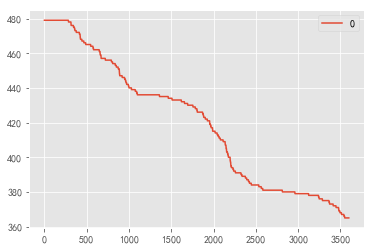

In [522]:
# plt.xlabel("建单时间-签合同时间")
# plt.ylabel("建单数量")
pd.DataFrame([len(new_follow[new_follow['间隔时间']>datetime.timedelta(minutes=i)]) for i in range(3600,7200,1)]).plot()

# 销售情况

In [ ]:
#产品分布图
#地域分布图

## 产品类型售卖分布

In [8]:
df_dingdan.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19515 entries, 0 to 19514
Data columns (total 34 columns):
编号         19515 non-null int64
客户姓名       19515 non-null object
流水号        19515 non-null int64
订单号        19515 non-null int64
订单数量       142 non-null float64
订单类型       19515 non-null object
空间风格       19515 non-null object
产品信息       19515 non-null object
产品类型       19515 non-null object
母空间类型      19515 non-null object
子空间类型      19515 non-null object
门店名称       19515 non-null object
门店类型       19515 non-null object
下单员工       19515 non-null object
预计发货       19515 non-null object
发货时间       14379 non-null object
订单状态       19515 non-null object
订单标签       5581 non-null object
建单日期       19515 non-null object
提交审核日期     18983 non-null object
下单完毕日期     1805 non-null object
审核日期       18832 non-null object
排产日期       17042 non-null object
区域         19515 non-null object
收款状态       19515 non-null object
收款日期       17435 non-null object
优惠券类型      0 non-null float64
优惠券减免金额  

In [11]:
df_dingdan=pd.read_excel('dingdan2018-06-26.xls')  

In [34]:
?legend

In [222]:
df_dingdan=df_dingdan[['空间风格','门店名称']]
df_dingdan['数量']=1
tmp=df_dingdan.groupby(['空间风格']).aggregate({"数量":sum}).reset_index()
BBB=tmp['空间风格']
AAA=tmp['数量']
pie = Pie( width=800,
          height=800, background_color='white')
pie.add('订单类型占比', BBB,AAA,is_label_show=True,  legend_pos='left')
pie.render('data/类型分布.html')

In [207]:
tmp=df_dingdan.groupby(['门店名称','空间风格']).aggregate({"数量":sum}).reset_index()
tmp1=tmp.copy()
tmp['区域']=[i.split('市')[0] for i in tmp['门店名称']]
lst=[]
for i in tmp['区域']:
    if '省' in i:
        lst.append(i.split('省')[1] )
    elif '区' in i:
        lst.append(i.split('区')[1] )
    else:
        lst.append(i)
tmp['区域']=lst
tmp.to_excel('城市分类.xls')

In [225]:
from pyecharts import Geo
from pyecharts import *
tmp=pd.read_excel('城市分类.xls')


In [1]:
len(str())

19

In [231]:
kinds=[i for i in tmp.sort_values('数量',ascending=False)['空间风格'].drop_duplicates()]
geo = Geo("", "", title_color="#fff",
          title_pos="center left", width=1000,
          height=700, background_color='#404a59')
geo.add_coordinate('广安', 105.56, 30.52)
geo.add_coordinate('宣城', 118.75, 30.95)
geo.add_coordinate('贵州', 106.90, 27.70)
geo.add_coordinate('郯城', 118.35, 34.61)
for kind in kinds[:3]:
    a=tmp[tmp['空间风格']==kind]
    data=[(i,j) for i,j in zip(a['区域'],a['数量'])]
    attr, value = geo.cast(data)
    geo.add(kind, attr, value, type="effectScatter", is_visualmap=True, visual_range=[0, 300],
tooltip_formatter=geo_formatter,visual_text_color='#fff',legend_pos='left',legend_text_color="#eee")
geo.render('data/销售分布表.html')

In [230]:
data=[(i,j) for i,j in zip(tmp['区域'],tmp['数量'])]
# Geo.add(geo_cities_coords={"广安": [105.56,30.52]})
def geo_formatter(params):
    print(params.value[1])
    return params.name + ' : ' + params.value[1]
geo = Geo("销售分布表", "data from crm", title_color="#fff",
          title_pos="center", width=800,
          height=500, background_color='#404a59')
attr, value = geo.cast(data)
geo.add_coordinate('广安', 105.56, 30.52)
geo.add_coordinate('宣城', 118.75, 30.95)
geo.add_coordinate('贵州', 106.90, 27.70)
geo.add_coordinate('郯城', 118.35, 34.61)
geo.add("总表", attr, value, type="effectScatter", is_visualmap=True, visual_range=[0, 300],tooltip_formatter=geo_formatter,visual_text_color='#fff',legend_pos='left',legend_text_color="#eee")
geo.render('data/销售分布表.html')


## 销售地域售卖分布

In [8]:
df_diyu =pd.read_excel('城市等级.xlsx')
df_diyu.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202 entries, 0 to 201
Data columns (total 2 columns):
城市等级    202 non-null int64
城市名称    202 non-null object
dtypes: int64(1), object(1)
memory usage: 3.2+ KB


In [16]:
df_diyu['城市']=[i[0]+'市' for i in df_diyu['城市名称'].str.split('（')]
df_diyu.head()

,城市等级,城市名称,城市
0,1,北京（全国政治、文化、教育中心）,北京市
1,1,上海（全国经济中心）,上海市
2,1,广州（经济发达，中国第三大城市）,广州市
3,1,深圳（经济发达、特区城市）,深圳市
4,1,天津（重要经济大港）,天津市


In [22]:
df_mendia=pd.read_excel('C:\\Users\\d\\物流\\门店数据.xls')
df_mendia['门店名称'].head(10)

0       新疆石河子温州商城店
1    新疆乌鲁木齐市红星美凯龙店
2         宁夏银川市建材店
3        甘肃临夏环城南路店
4        甘肃陇南成县沿街店
5          甘肃平凉广场店
6        甘肃嘉峪关建材场店
7          甘肃兰州建材店
8       甘肃兰州红星美凯龙店
9         陕西安康天贸城店
Name: 门店名称, dtype: object

# 下单相关

## 数据清洗

In [57]:
tmp1=df_budan[['流水号','补单建单人','补单建单时间-T','补单号']]
tmp2 = df_dingdan[['流水号','下单员工','建单日期','门店名称']]


由于无法将订单号和补单号关联起来，所以无法查看一个订单会不会有多个补单的情况

In [58]:
res =tmp2.merge(tmp1,how='outer')

# .dropna(subset=['建单日期'])
res.head()

,流水号,下单员工,建单日期,门店名称,补单建单人,补单建单时间-T,补单号
0,10005150,庄卫东,2018-06-23 13:51:51,浙江省杭州市萧山区直营旗舰店,NaN,NaN,NaN
1,10005150,庄卫东,2018-06-23 13:49:42,浙江省杭州市萧山区直营旗舰店,NaN,NaN,NaN
2,10005150,庄卫东,2018-06-23 13:48:21,浙江省杭州市萧山区直营旗舰店,NaN,NaN,NaN
3,10005158,庄卫东,2018-06-23 10:14:39,浙江省杭州市萧山区直营旗舰店,NaN,NaN,NaN
4,10005158,庄卫东,2018-06-23 10:14:00,浙江省杭州市萧山区直营旗舰店,NaN,NaN,NaN


In [89]:
res.columns=["流水号",'下单员工','建单时间','门店名称',"补单建单人",'补单建单时间','补单号']
res=res.drop_duplicates(['建单时间','下单员工'])
# res.head(1)
res.to_excel("建单-补单时间.xls",index=False,encoding="gbk")



In [281]:
res.shape

(19513, 7)

In [282]:
df_dingdan.shape

(19515, 5)

## 下单至补单持续时间估算

In [90]:
# 根据订单号合并订单，补单数据
res['建单时间']=pd.to_datetime(res['建单时间'])
res['补单建单时间']=pd.to_datetime(res['补单建单时间'])
res["持续时间"]=res['补单建单时间']-res['建单时间']
res["持续时间"]=res["持续时间"].dt.days.dropna().astype(int)
res["建单时间"]
res.to_excel("建单-补单时间.xls",index=False,encoding="gbk")

### 构建时间表

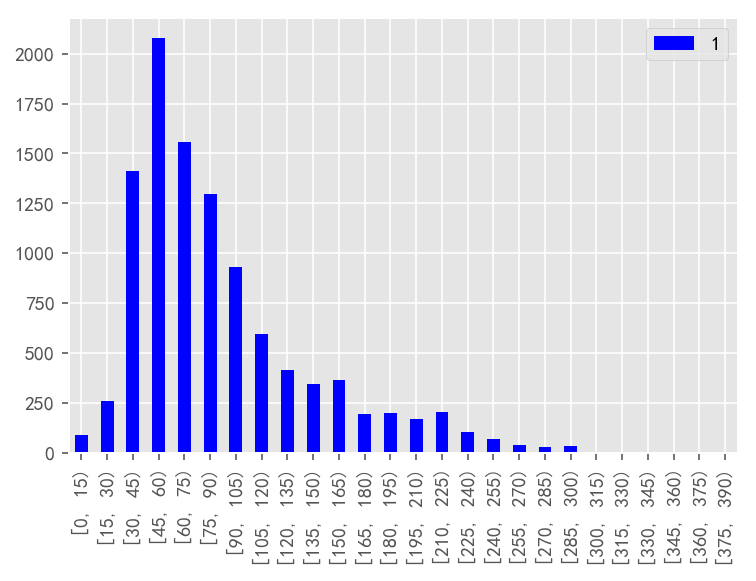

In [94]:
res=res.dropna()

fenzu(res["持续时间"])
#pd.DataFrame(pinshu).boxplot()

#res[(res["持续时间"]>180)&(res["持续时间"]<240)]

### 时间置信区间

In [98]:
#eg
%config InlineBackend.figure_format = 'retina'
plt.rcParams['font.sans-serif']=['SimHei'] #用来正常显示中文标签 
standard_norm = stats.norm  #标准正态分布
t_dist = scipy.stats.t            #标准t分布
x = np.arange(-4, 4,0.01)
plt.plot(x, standard_norm.pdf(x), label='standard normal',alpha=0.5)
plt.plot(x, t_dist.pdf(x, df=30), label='t distribution',alpha=0.5)
plt.title('自由度为30的t分布 与 标准正态分布 对比图')
plt.legend()
plt.show()

NameError: name 'stats' is not defined

In [100]:
during_time=res['持续时间']
during_time.head(1)

244    14.0
Name: 持续时间, dtype: float64

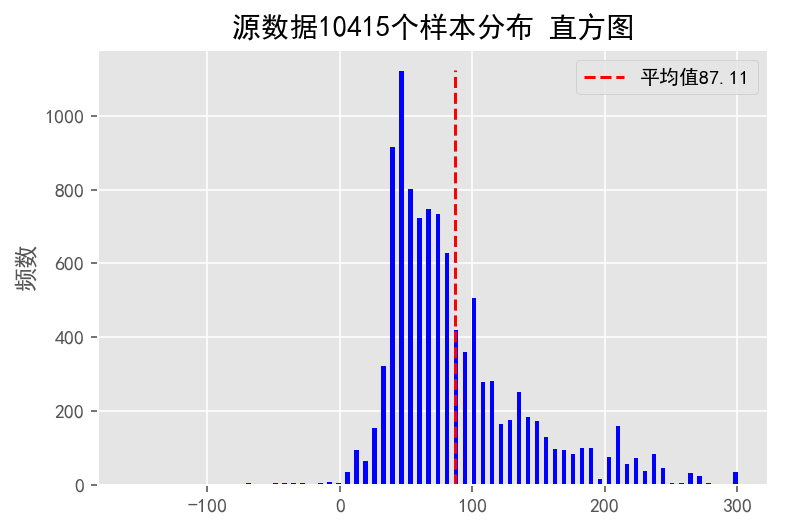

95.0% Confidence Interval: ( 86.08, 88.13)


In [101]:

D_time=int(ci_t(during_time,0.95)[1])+1

C:\Users\d\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


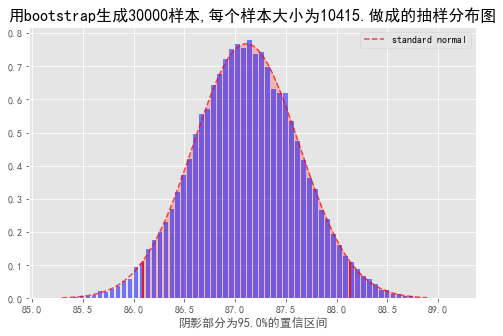

用bootstrap生成抽样分布方法,计算出在95.0%的置信区间为: 86.09322851656265 -- 88.13567450792127


array([86.09322852, 88.13567451])

In [288]:
bootstrap(during_time,0.95,30000)

### 结论

95%的合同建单到补单的时间为87-89天

## 单合同订单数量统计

6.0


[(1100, 1200], (400, 500], (300, 400], (200, 300], (200, 300], ..., (0, 100], (0, 100], (0, 100], (0, 100], (0, 100]]
Length: 51
Categories (12, interval[int64]): [(0, 100] < (100, 200] < (200, 300] < (300, 400] ... (800, 900] < (900, 1000] < (1000, 1100] < (1100, 1200]]

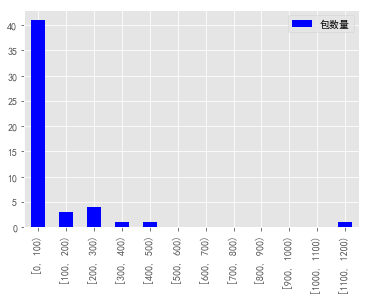

In [84]:
baoshu=df_dingdan['流水号'].value_counts()
fenzu(baoshu.value_counts(),list(range(0,1300,100)),"包数量")
print(baoshu.value_counts().median()) 
pd.cut(baoshu.value_counts().values,list(range(0,1300,100)))

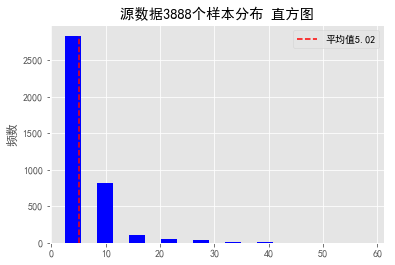

95.0% Confidence Interval: ( 4.84, 5.20)


C:\Users\d\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


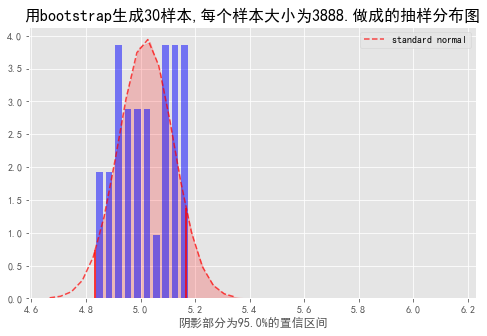

用bootstrap生成抽样分布方法,计算出在95.0%的置信区间为: 4.834310699588477 -- 5.165888631687243


array([4.8343107 , 5.16588863])

In [85]:
ci_t(baoshu,0.95)[1]
bootstrap(baoshu,0.95,30)

### 结论

单个合同的订单大致在5-6个订单

## 建单时间

In [10]:
creat_time=df_dingdan
# creat_time['建单日期']=
creat_time['建单日期']=pd.to_datetime(creat_time['建单日期'].str[11:])


# df_dingdan['建单日期']=pd.to_datetime(df_dingdan['建单日期'])

# creat_time=df_dingdan['建单日期'].value_counts()

In [11]:
creat_time['次数']=1
creat_time_num=pd.DataFrame(creat_time['建单日期'].value_counts())
creat_time.head()

,流水号,下单员工,建单日期,门店名称,次数
1,10005150,庄卫东,2018-07-03 13:51:51,浙江省杭州市萧山区直营旗舰店,1
2,10005150,庄卫东,2018-07-03 13:49:42,浙江省杭州市萧山区直营旗舰店,1
3,10005150,庄卫东,2018-07-03 13:48:21,浙江省杭州市萧山区直营旗舰店,1
4,10005158,庄卫东,2018-07-03 10:14:39,浙江省杭州市萧山区直营旗舰店,1
5,10005158,庄卫东,2018-07-03 10:14:00,浙江省杭州市萧山区直营旗舰店,1


In [12]:
tmp=creat_time.drop_duplicates('门店名称')['门店名称'].tolist()
ddd=creat_time.groupby(['门店名称']).aggregate({"次数":sum}).sort_values('次数',ascending=False)
d_tmp=ddd.index.tolist()



### 分店显示

<Figure size 1440x7200 with 0 Axes>

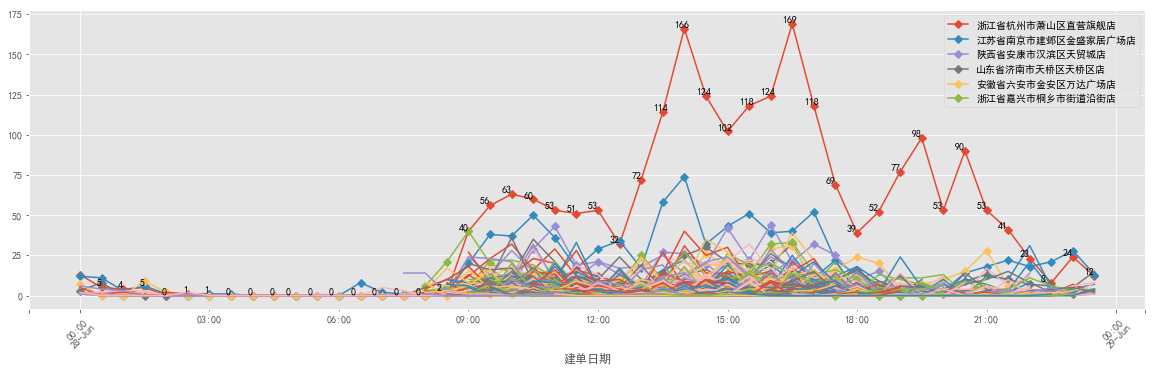

<Figure size 1440x7200 with 0 Axes>

In [20]:

# creat_time_num.columns=['次数']
# creat_time_num
a=1
b=10
for i in d_tmp[a:]:
    y=creat_time[creat_time['门店名称']==i].groupby([pd.Grouper(key="建单日期",freq='30min')])["次数"].sum()
# my_finder(y,y,"浙江省杭州市萧山区直营旗舰店","时间",np.arange(0, 200, 10))
    if d_tmp.index(i)==a:
        y.plot(kind='line',label=i,marker="D")
        for i in range(1,len(y)):
            plt.text(y.index[i]+datetime.timedelta(minutes = -len(str(i))*7),y[i]+1,y[i])
    elif d_tmp.index(i)<=(a+5):
        y.plot(kind='line',label=i,marker="D") 
    else:
        y.plot(kind='line',label="")  
plt.legend()
fig = plt.gcf()
pl.xticks(rotation=45)#x轴角度旋转
fig.set_size_inches(20,5.5)
fig.savefig("分店显示.png",dpi=100)
plt.figure(figsize=(20,100))


In [8]:
creat_time[creat_time['门店名称']=='浙江省杭州市萧山区直营旗舰店'].head()

,流水号,下单员工,建单日期,门店名称,次数
1,10005150,庄卫东,2018-06-28 13:51:51,浙江省杭州市萧山区直营旗舰店,1
2,10005150,庄卫东,2018-06-28 13:49:42,浙江省杭州市萧山区直营旗舰店,1
3,10005150,庄卫东,2018-06-28 13:48:21,浙江省杭州市萧山区直营旗舰店,1
4,10005158,庄卫东,2018-06-28 10:14:39,浙江省杭州市萧山区直营旗舰店,1
5,10005158,庄卫东,2018-06-28 10:14:00,浙江省杭州市萧山区直营旗舰店,1


### 总显示

<Figure size 1440x7200 with 0 Axes>

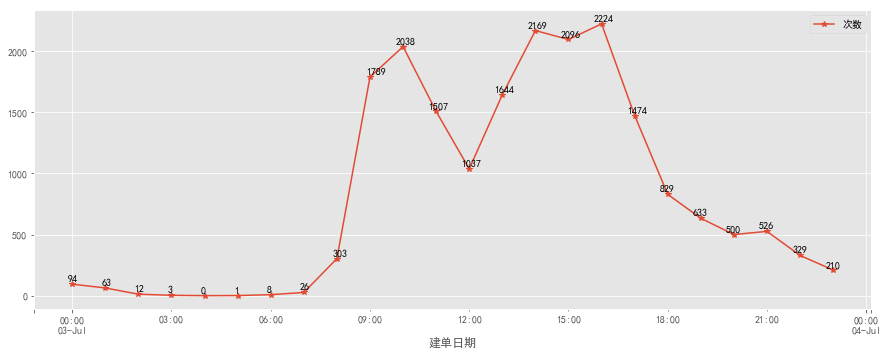

<Figure size 1440x7200 with 0 Axes>

In [13]:
y=creat_time.groupby([pd.Grouper(key="建单日期",freq='60min')])["次数"].sum()
# my_finder(y,y,"浙江省杭州市萧山区直营旗舰店","时间",np.arange(0, 200, 10))
y.plot(kind='line',marker="*")
plt.legend()
#plt.annotate(y[i],) 有箭头的
for i in range(0,len(y)):
    plt.text(y.index[i]+datetime.timedelta(minutes = -len(str(i))*7),y[i]+20,y[i])
# xmajorLocator=dates.HourLocator(1)

#my_y_ticks = np.arange(0, y.index[1], 1)
#plt.xticks=my_y_ticks
fig = plt.gcf()
#fig.xaxis.set_major_locator(dates.HourLocator(byhour=range(0, 24, 1)))
#plt.xticks(rotation=45)#x轴角度旋转
fig.set_size_inches(15,5.5)
fig.savefig("所有门店.png",dpi=100)
plt.figure(figsize=(20,100))

### 结论

建单时间大致在工作时间高峰期在9-10点，13-16点，工作时间大致会持续到晚上9点左右，但明显减少

## 补单时间

### 总显示

In [ ]:
df_budan_time.info

In [3]:
df_budan_time=pd.read_excel('补单带时间.xls')
df_budan_time=df_budan_time[["CID","ADD_TIME"]]
df_budan_time.columns=["流水号","补单时间"]
# df_budan_time.head()

creat_time=df_budan_time.dropna()
creat_time['补单时间-s']=pd.to_datetime([str(i)[11:] for i in creat_time['补单时间']])

creat_time['次数']=1
creat_time_num=pd.DataFrame(creat_time['补单时间-s'].value_counts())

,流水号,补单时间
0,10003843,6/25/2018 09:01:19
1,10003921,6/24/2018 19:52:58
2,10003921,6/24/2018 19:40:24
3,10003223,6/24/2018 18:23:01
4,10003223,6/24/2018 18:18:36


<Figure size 1440x7200 with 0 Axes>

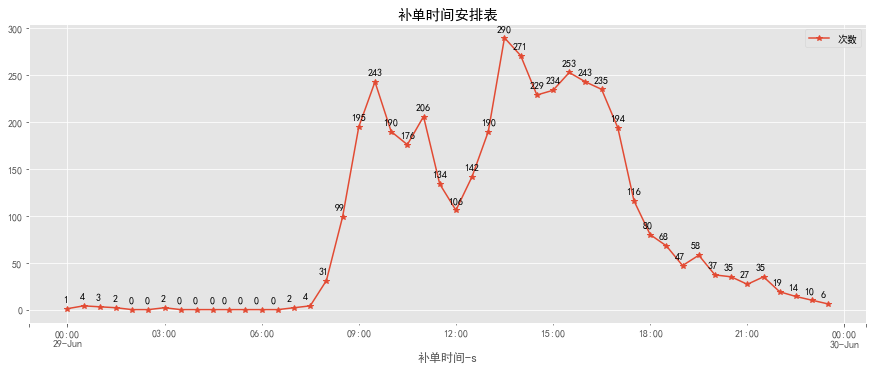

<Figure size 1440x7200 with 0 Axes>

In [58]:
y=creat_time.groupby([pd.Grouper(key="补单时间-s",freq='30min')])["次数"].sum()
# my_finder(y,y,"浙江省杭州市萧山区直营旗舰店","时间",np.arange(0, 200, 10))
y.plot(kind='line',marker="*")
plt.legend()
#plt.annotate(y[i],) 有箭头的
for i in range(0,len(y)):
    plt.text(y.index[i]+datetime.timedelta(minutes = -len(str(i))*7),y[i]+7,y[i])
    plt.title("补单时间安排表")
# xmajorLocator=dates.HourLocator(1)

#my_y_ticks = np.arange(0, y.index[1], 1)
#plt.xticks=my_y_ticks
fig = plt.gcf()
#fig.xaxis.set_major_locator(dates.HourLocator(byhour=range(0, 24, 1)))
#plt.xticks(rotation=45)#x轴角度旋转
fig.set_size_inches(15,5.5)
fig.savefig("总-补单时间.png",dpi=100)
plt.figure(figsize=(20,100))

### 结论

补单时间大致在工作时间高峰期在9-10点，13-14点

## 订单状态查看

In [49]:
#订单的状态在合同之前的有几个，大部分时间卡在哪里


# 订单与补单

In [298]:
res=res1.fillna(1)
A=res.at[1,"补单建单时间-T"]#取得某值
res['补单数量'] = res["补单建单时间-T"].apply(lambda x: 0 if x==1  else 1)# 按条件填充
res['建单数量']= 1
#res=res.drop("补单建单时间",axis=1)
res.head()
res.to_csv("2.csv",index=False,encoding="gbk")

In [308]:
str(pd.to_datetime(res1["建单日期"].dropna().max())-datetime.timedelta(days=75)).split(" ")[0]


'2018-03-10'

0    1.0
dtype: float64

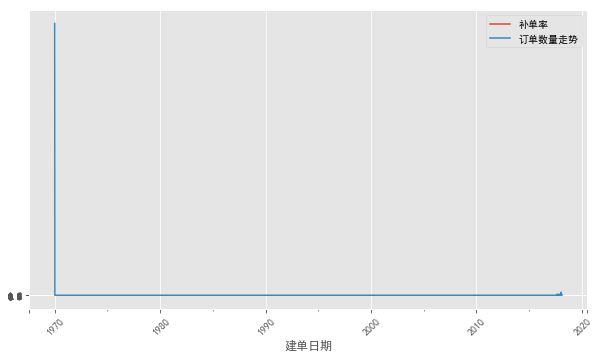

<Figure size 1440x7200 with 0 Axes>

In [312]:
'''
之前得出的结论建单到补单置信区间大致在87-89天左右
'''
res["建单日期"]=pd.to_datetime(res["建单日期"])
res["建单日期1"]=pd.to_datetime(res["建单日期"])
s = res
s = s.set_index("建单日期1")
s1 =s[:str(pd.to_datetime(res1["建单日期"].dropna().max())-datetime.timedelta(days=D_time)).split(" ")[0]]#之前得出的结论建单到补单置信区间大致在73-75天左右
#s1=s[:"2018-6"]
y=s1.groupby([pd.Grouper(key="建单日期",freq='1W')])["建单数量","补单数量"].sum()
x=y["补单数量"]/y["建单数量"]
plt.style.use('seaborn-bright')
my_finder(y["建单数量"]/y["建单数量"].max(),x,"订单数量走势","补单率")

pd.DataFrame(x).median()
#s = s.insert(1,"建单时间1",res["建单时间"])
#s = s.set_index("建单时间")
#s


711

In [156]:

df.loc["3000":,['问题反馈','补单原因','门店名称']]

KeyError: "None of [['问题反馈', '补单原因', '门店名称']] are in the [columns]"

## 补单中包含特定问题的选项

In [23]:
pattern="生产 |错"

df1 = df[:]
for i,j in zip(df1.index,df1["问题反馈"].str.contains(pattern)):
    if j==False:
        df1=df1.drop(i , axis =0)
    else:
        continue
df1


,补单建单时间,问题反馈,补单原因,门店名称,补单建单人
18,2018-06-21,安装错误,"安装错误,安装损坏,安装错误",浙江省绍兴市新昌县红星美凯龙店,吕磊鑫
27,2018-06-21,门板漏下，收口条漏下，门板尺寸错误,"设计师错误,设计出错,其他",浙江省金华市金东区布兰莎,倪赛勇
49,2018-06-20,1拆单错误,"客户新增,其他,其他",浙江省杭州市萧山区直营旗舰店,董青楠
50,2018-06-20,背板尺寸错误，层板未打孔,NaN,浙江省台州市路桥区沿街店,周丹佳
72,2018-06-19,伊琳娜台面造型左右做错,"采购错误,外协错误,厂家做错",浙江省杭州市萧山区展示设计中心,杨轶
76,2018-06-19,伊琳娜台面造型左右做错,"采购错误,外协错误,厂家做错",浙江省杭州市萧山区展示设计中心,杨轶
78,2018-06-19,伊琳娜台面造型左右做错 楣板造型做错,"采购错误,外协错误,厂家做错 生产错误,开料错误,尺寸开错",浙江省杭州市萧山区展示设计中心,杨轶
86,2018-06-19,1、补一组柜子和导轨 原因：设计出错,"设计师错误,设计出错,其他",江苏省南京市建邺区金盛家居广场店,胡俊杰
89,2018-06-19,1、补拉手两个FJ119 2、补封板2000*18*68雅典白一块和2000*103*9雅...,"设计师错误,设计出错,其他",江苏省南京市建邺区金盛家居广场店,胡俊杰
105,2018-06-19,衣帽间左右上下尺寸有误差顶线无法安装最右侧上柜没有避墙梁 一块异形侧板发错 2个格子架运输破...,"设计师错误,量尺错误,其他 客户新增,其他,其他 采购错误,外协错误,厂家做错 运输出错,物...",浙江省杭州市萧山区展示设计中心,杨轶


In [162]:
df.iloc[3:4,:]

,流水号,补单建单时间
5,10001085,2018-06-05


## 补单特定建单人

In [147]:
df[df['补单建单人'].isin(['杜东辉'])]


,补单建单时间,问题反馈,补单原因,门店名称,补单建单人
27,2018-06-05,收口板、拉手,NaN,浙江省杭州市萧山区直营旗舰店,杜东辉
92,2018-06-02,圆弧层板,"生产错误,封边错误,封边质量问题",浙江省杭州市萧山区直营旗舰店,杜东辉
98,2018-06-02,格子板,"客户新增,其他,其他 运输出错,物流损坏,破损",浙江省杭州市萧山区直营旗舰店,杜东辉
176,2018-05-27,顶线,"客户新增,其他,其他 生产错误,包装出错,漏包",浙江省杭州市萧山区直营旗舰店,杜东辉
177,2018-05-27,顶底板、左右侧板,"客户新增,其他,其他",浙江省杭州市萧山区直营旗舰店,杜东辉
178,2018-05-27,抽面,"生产错误,开料错误,尺寸开错",浙江省杭州市萧山区直营旗舰店,杜东辉
179,2018-05-27,收口板,"生产错误,包装出错,漏包",浙江省杭州市萧山区直营旗舰店,杜东辉
309,2018-05-20,抽面、拉手,"物料问题,其他,其他 安装错误,安装损坏,安装错误",浙江省杭州市萧山区直营旗舰店,杜东辉
426,2018-05-14,收口板,"生产错误,包装出错,漏包",浙江省杭州市萧山区直营旗舰店,杜东辉
428,2018-05-14,门板,"生产错误,开料错误,尺寸开错",浙江省杭州市萧山区直营旗舰店,杜东辉


(array([ 4., 11., 12., 21., 18., 19.,  8.,  4.,  2.,  1.]),
 array([-2.49275769, -1.96487263, -1.43698757, -0.90910251, -0.38121745,
         0.14666761,  0.67455267,  1.20243773,  1.73032279,  2.25820785,
         2.78609291]),
 <a list of 10 Patch objects>)

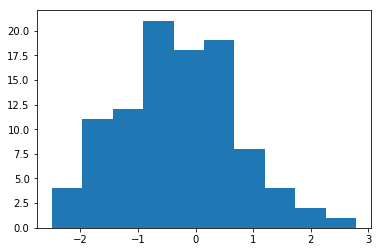

In [295]:
plt.hist(random.randn(100))

36
3718
补单原因不为空率：99.03173749327595%


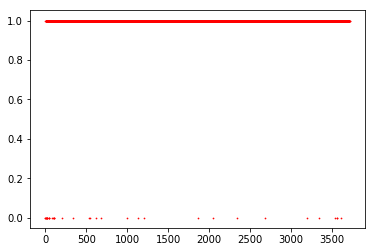

In [196]:
dfnull=df.isnull()
x = df.index
y=[]
n=0
for i in dfnull["补单原因"]:
    if i!=True:
        y = y+[1]
        n=n+1
    else:
        y = y+[0]

size = 0.5
color = 'r'
plt.scatter(x, y, size, color)
print(len(dfnull["补单原因"])-n)
print(len(dfnull["补单原因"]))
print("补单原因不为空率："+str(n/len(dfnull["补单原因"])*100)+"%")


##  错误最多的设计师以及所在门店

In [3]:
df1=pd.DataFrame(columns=["门店名称","错误数量"])
for x in df["补单建单人"].value_counts().head(40).index:
    df1.loc[x]=[df[df["补单建单人"]==x]["门店名称"].drop_duplicates().values[0]]+[df["补单建单人"].value_counts()[x]]  
df1
    

,门店名称,错误数量
杨轶,浙江省杭州市萧山区展示设计中心,401
陶晓敏,浙江省杭州市萧山区展示设计中心,277
杜东辉,浙江省杭州市萧山区直营旗舰店,145
胡俊杰,江苏省南京市建邺区金盛家居广场店,140
孔英杰,浙江省杭州市萧山区直营旗舰店,120
卢昊,浙江省杭州市萧山区直营旗舰店,109
杨霄箫,浙江省湖州市南浔区建材店,99
童钦炆,浙江省杭州市萧山区直营旗舰店,75
朱丽媛,浙江省杭州市萧山区直营旗舰店,55
汪小九,江苏省苏州市太仓市西街商铺沿街店,54


#  补单率

In [323]:
res.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4241 entries, 0 to 4240
Data columns (total 11 columns):
流水号         4241 non-null int64
补单建单人       4241 non-null object
补单建单时间-T    4241 non-null object
补单号         4241 non-null float64
订单号         4241 non-null int64
下单员工        4241 non-null object
建单日期        4241 non-null datetime64[ns]
门店名称        4241 non-null object
补单数量        4241 non-null int64
建单数量        4241 non-null int64
建单日期1       4241 non-null datetime64[ns]
dtypes: datetime64[ns](2), float64(1), int64(4), object(4)
memory usage: 557.6+ KB


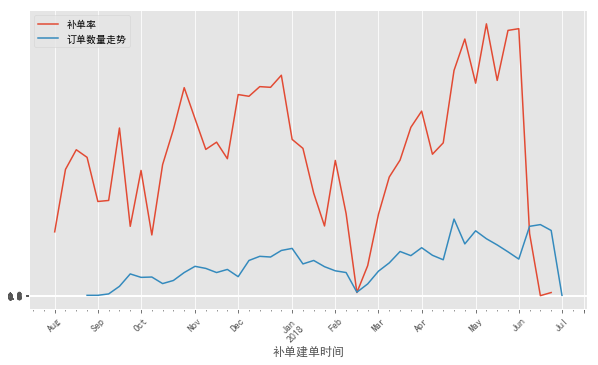

<Figure size 1440x7200 with 0 Axes>

In [334]:
#x=df["补单建单时间"].value_counts().index
#y=df["补单建单时间"].value_counts().sort_index()#  时间查询
df=res
df[['补单建单时间','建单时间']]=res[['补单建单时间-T','建单日期']]
df=pd.DataFrame(df[["补单建单时间"]])
df["数量"]=1
df["补单建单时间"]=pd.to_datetime(df["补单建单时间"])
x=df.groupby([pd.Grouper(key="补单建单时间",freq='1W')])["数量"].sum()
df_dingdan=pd.DataFrame(df_dingdan[["建单日期"]])
df_dingdan["数量"]=1
df_dingdan["建单日期"]=pd.to_datetime(df_dingdan["建单日期"])
y=df_dingdan.groupby([pd.Grouper(key="建单日期",freq='1W')])["数量"].sum()
my_finder(x,y)


In [163]:
df[df["门店名称"]=="浙江省杭州市萧山区直营旗舰店"]["补单建单人"].value_counts()

杜东辉    145
孔英杰    120
卢昊     109
童钦炆     75
朱丽媛     55
祝喜健     53
吴艳培     51
黄勇      45
胡涛涛     44
闫佳文     35
董青楠     34
黄巧雯     17
虞双      13
Name: 补单建单人, dtype: int64

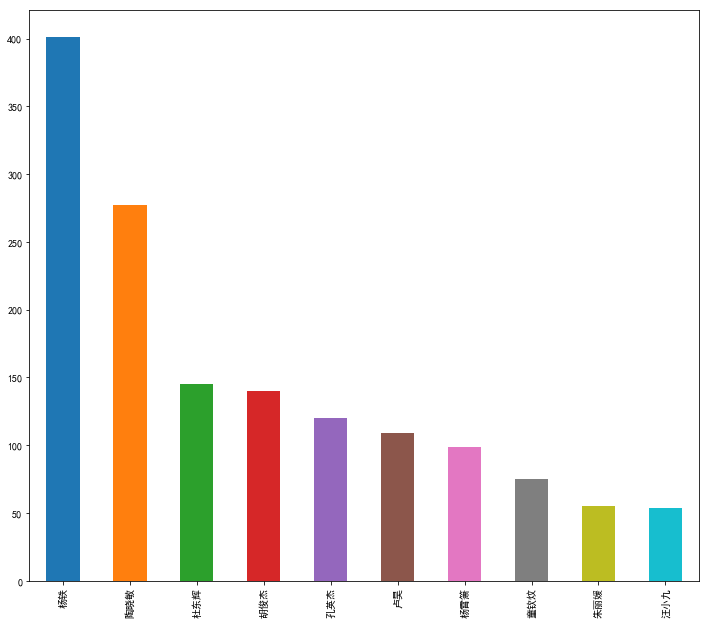

In [26]:
plt.rcParams['font.sans-serif'] = ['SimHei'] #用来正常显示中文标签
x=df["补单建单人"].value_counts().index
y=df["补单建单人"].value_counts#  错误最多的设计师以及所在门店().head(10)
y.plot(kind='bar')
fig = plt.gcf()
fig.set_size_inches(12.0,10.5)
fig.savefig("text1.png",dpi=100)
plt.figure(figsize=(20,100))

## 数据录入

In [6]:
df1=pd.read_excel('dingdan2018-06-26.xls')  
df2=pd.read_excel('budan2018-06-26.xls')  

df_budan=df2[['流水号','补单建单人','补单建单时间','补单原因','问题反馈']]

df_dingdan=df1[['流水号','下单员工','建单日期','门店名称']]

res=df_dingdan.merge(df_budan,left_on="流水号",right_on='流水号',how="outer")
res.reset_index
res["建单日期"]=pd.to_datetime(res["建单日期"])
res.head()
res.to_excel("tmp.xls")

## 补单率(按设计师查看)

In [8]:
res=res.dropna(subset=["下单员工"])
res["补单数量"]=res["补单建单人"].apply(lambda x: 0 if type(x)!=str  else 1)
res["建单数量"]=1
temp=res.groupby(['流水号','下单员工']).aggregate({'补单数量':sum,'建单数量':sum,'建单日期':min})
temp['建流水数量']=1
temp['流水补单数量']=temp["补单数量"].apply(lambda x: 0 if x == 0  else 1)
temp.head()
temp=temp.reset_index()
temp['建单日期']=pd.to_datetime(temp['建单日期'])
weiyi_yuangong=temp.groupby('下单员工').aggregate({'补单数量':sum,'建单数量':sum,'建单日期':min}).sort_values('建单数量',ascending=False)
weiyi_yuangong=weiyi_yuangong.reset_index()
weiyi_yuangong = weiyi_yuangong.drop_duplicates('下单员工')
weiyi_yuangong=weiyi_yuangong.sort_values('建单数量',ascending=False)
weiyi_yuangong.index=(list(range(0,len(weiyi_yuangong))))

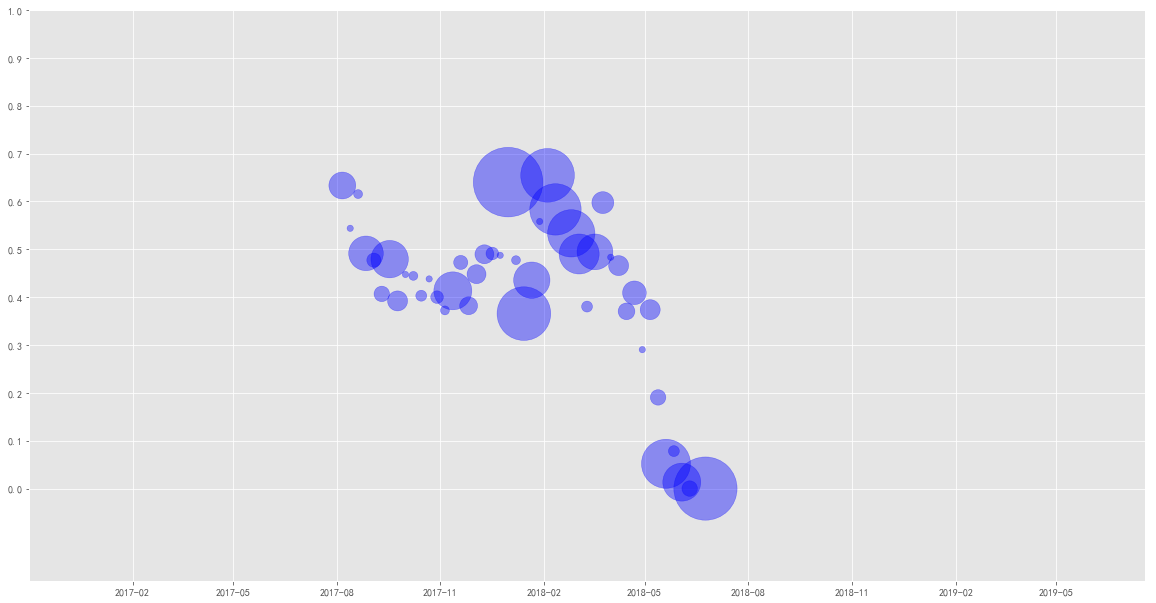

In [5]:
#  y=temp[temp['下单员工']==weiyi_yuangong['下单员工'][i]]
y=temp.groupby([pd.Grouper(key="建单日期",freq='1w')])["建流水数量","流水补单数量"].sum()
x=y["流水补单数量"]/y["建流水数量"]
plt.style.use('seaborn-bright')
plt.scatter(y.index,x,s=temp['建单数量']*40,color="b",alpha=0.4)
#plt.scatter(y.index,x,s=temp['补单数量']*40)
#x.plot(kind='line',alpha=0.4)#label=weiyi_yuangong['下单员工'][i],alpha=0.4)
my_y_ticks = np.arange(0, 1.1, 0.1)
plt.yticks(my_y_ticks)
#plt.legend()
fig = plt.gcf()
fig.set_size_inches(20,10.5)
fig.savefig("补单率.png",dpi=100)

In [10]:
for i in range(0,len(weiyi_yuangong)):
  #  y=temp[temp['下单员工']==weiyi_yuangong['下单员工'][i]]
    y=temp[temp['下单员工']==weiyi_yuangong['下单员工'][i]].groupby([pd.Grouper(key="建单日期",freq='8w')])["建流水数量","流水补单数量"].sum()
    x=y["流水补单数量"]/y["建流水数量"]
    plt.style.use('seaborn-bright')
    plt.scatter(y.index,x,s=temp['建单数量']*40,color="b",alpha=0.4)
    x.plot()
    #plt.scatter(y.index,x,s=temp['补单数量']*40)
    #x.plot(kind='line',alpha=0.4)#label=weiyi_yuangong['下单员工'][i],alpha=0.4)
    my_y_ticks = np.arange(0, 1.1, 0.1)
    plt.yticks(my_y_ticks)
    #plt.legend()
fig = plt.gcf()
fig.set_size_inches(20,10.5)
fig.savefig("补单率.png",dpi=100)

NameError: name 'weiyi_yuangong' is not defined

In [60]:
#res[res["下单员工"].isnull().values==True].dropna()
res=res.dropna(subset=["下单员工"])
res["补单数量"]=res["补单建单人"].apply(lambda x: 0 if type(x)!=str  else 1)
res["建单数量"]=1
temp=res.groupby(['流水号','下单员工']).aggregate({'补单数量':sum,'建单数量':sum,'建单日期':min})
temp['建流水数量']=1
temp['流水补单数量']=temp["补单数量"].apply(lambda x: 0 if x == 0  else 1)
temp.head()
temp.to_excel('temp.xls')

#res[res["流水号"].isin([10005068])]
#def my_test(x,y):
#    if x!=y and x!=0:
#        return x
#    else:
#        return "相等或0"  
#temp['Value'] = temp.apply(lambda row: my_test(row['补单数量'], row['建单数量']), axis=1)
#temp[temp['Value'].isin(["相等或0"])==False]


In [ ]:
#设计师建单数量

## 补单率(按流水查看）

In [6]:
#res[res["下单员工"].isnull().values==True].dropna()
res=res.dropna(subset=["门店名称"])
res["补单数量"]=res["补单建单人"].apply(lambda x: 0 if type(x)!=str  else 1)
res["建单数量"]=1
temp=res.groupby(['流水号','门店名称']).aggregate({'补单数量':sum,'建单数量':sum,'建单日期':min})
temp['建流水数量']=1
temp['流水补单数量']=temp["补单数量"].apply(lambda x: 0 if x == 0  else 1)
temp.head()
temp.to_excel('temp.xls')
#res[res["流水号"].isin([10005068])]
#def my_test(x,y):
#    if x!=y and x!=0:
#        return x
#    else:
#        return "相等或0"  
#temp['Value'] = temp.apply(lambda row: my_test(row['补单数量'], row['建单数量']), axis=1)
#temp[temp['Value'].isin(["相等或0"])==False]


In [39]:
temp=pd.read_excel('temp.xls') 
temp['建单日期']=pd.to_datetime(temp['建单日期'])

In [9]:
# D_time=87
temp_75=temp[temp['建单日期']<(temp["建单日期"].max()-datetime.timedelta(days=D_time))]

In [61]:
weiyi_yuangong=pd.read_excel('temp.xls') 
weiyi_yuangong=weiyi_yuangong.groupby('门店名称').aggregate({'补单数量':sum,'建单数量':sum,'建单日期':min}).sort_values('建单数量',ascending=False)
weiyi_yuangong.to_excel('weiyi_yuangong.xls')
weiyi_yuangong=pd.read_excel('weiyi_yuangong.xls') 
weiyi_yuangong = weiyi_yuangong.drop_duplicates('门店名称')
weiyi_yuangong=weiyi_yuangong.sort_values('建单数量',ascending=False)
weiyi_yuangong.index=(list(range(0,len(weiyi_yuangong))))
##list(range(1,len(weiyi_yuangong)))


### 补单率

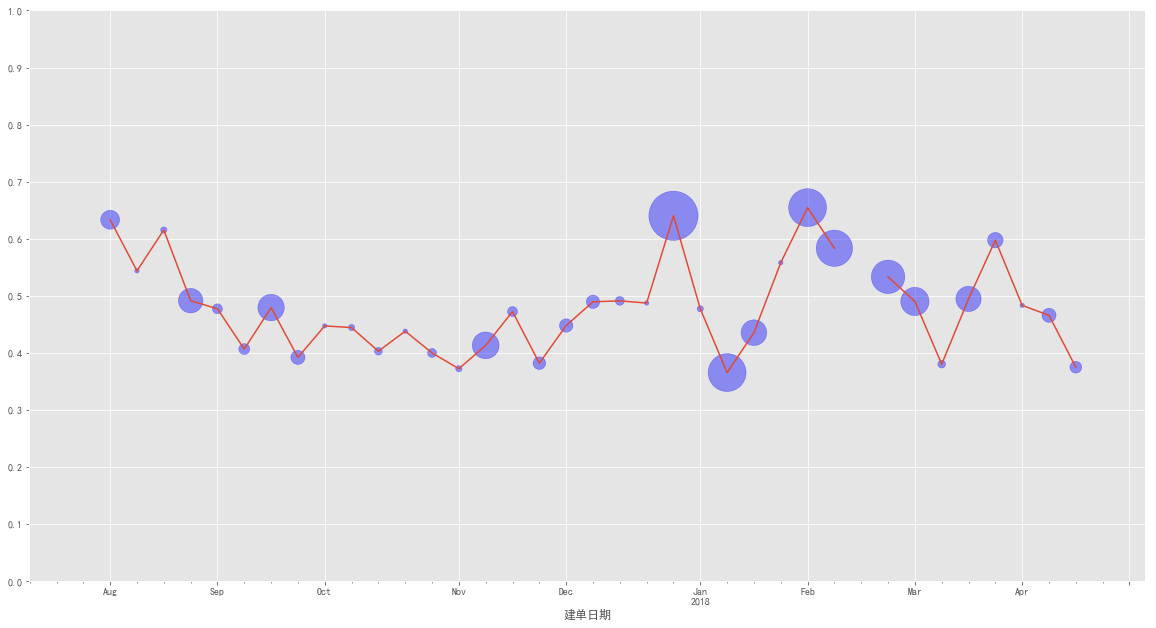

In [101]:
#for i in range(1,len(weiyi_yuangong)):
#y=temp[temp['门店名称']==weiyi_yuangong['门店名称'][i]].groupby([pd.Grouper(key="建单日期",freq='1w')])["建流水数量","流水补单数量"].sum()
y=temp_75.groupby([pd.Grouper(key="建单日期",freq='1w')])["建流水数量","流水补单数量"].sum()
x=y["流水补单数量"]/y["建流水数量"]

plt.style.use('ggplot')    
#plt.scatter(y.index,x,s=temp['补单数量']*40)
x.plot(kind='line',label="补单率")
plt.scatter(y.index,x,s=temp['建单数量']*20,color="b",alpha=0.4,label="订单量")
my_y_ticks = np.arange(0, 1.1, 0.1)
plt.yticks(my_y_ticks)
#plt.legend()
fig = plt.gcf()
fig.set_size_inches(20,10.5)
fig.savefig("补单率-去除第1家.png",dpi=100)


In [102]:
#存储x值
%store x

Stored 'x' (Series)


In [104]:
%store z

Stored 'z' (DataFrame)


0.4473684210526316

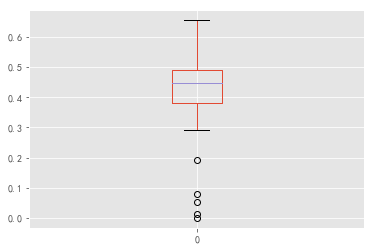

In [10]:
budan_rate=x.dropna().value_counts().index
pd.DataFrame(budan_rate).boxplot()
pd.Series(budan_rate).describe()
pd.Series(budan_rate).median()

### 环比

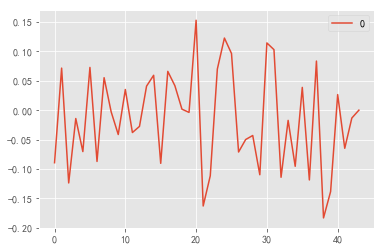

In [52]:
# y.dropna()['补单率'][1:]-y.dropna()['补单率'][:-1]
y['补单率']=x
(y.dropna()['补单率'].values[1:]-y.dropna()['补单率'].values[:-1])
pd.DataFrame(y.dropna()['补单率'].values[1:]-y.dropna()['补单率'].values[:-1]).plot()

### 结论

每一个合同的补单率均值在42.3%。补单率中值在44.7%，说明大部分合同的补单率会在42.3%之下。订单几乎有一半的补单率。而且近一年补单率并没有很大程度上的改变。下一步需要查看订单补单的原因具体哪些是工厂的原因，哪些是门店的原因，哪些是客户新增的需要进一步判断

## 补单率（按订单查看）

### 取得数据

In [15]:
df_rate=pd.read_excel("tmp.xls")
df_rate['补单建单时间']=df_budan['补单建单时间-T']
df_rate.dropna().head(1)
# res['补单数量'] = res["补单建单时间"].apply(lambda x: 0 if x==1  else 1)
# df_rate.dropna(subset=['下单员工'])[df_rate['补单原因'].str.contains('量尺错误')]

,流水号,下单员工,建单日期,门店名称,补单建单人,补单建单时间,补单原因,问题反馈
244,10005043,何家欢,2018-06-04 12:42:46,浙江省湖州市长兴县沿街店,何家欢,6/17/2018 17:19:06,"客户新增,其他,其他",客户临时要求修改增加的东西


In [16]:
df_rate=df_rate.dropna(subset=['下单员工'])
df_rate['补单数量'] = df_rate["补单建单人"].apply(lambda x: 0 if type(x)==float  else 1)
df_rate['建单数量'] = 1
# df_rate.iloc[14181]
tmp=df_rate.groupby(['下单员工','门店名称']).agg({"补单数量":sum,'建单数量':sum})
tmp.reset_index()[['门店名称','下单员工','建单数量','补单数量']]
tmp.head()

,,补单数量,建单数量
下单员工,门店名称,,
丁晨轩,江苏省泰州市泰兴市上东一品店,8,19
丁欣悦,湖北省襄阳市谷城县沿街店,5,6
丁燕倩,江苏省苏州市吴中区东方大道店,43,50
丁阿根,江苏省泰州市海陵区建材市场店,49,49
万小亮,安徽省芜湖市居然之家店,18,23


<span class="burk">存在同一员工不在同一个店的情况</span>

In [186]:
tmp.reset_index()[tmp.reset_index().duplicated(subset = ['下单员工'],keep=False)].head()

,下单员工,门店名称,补单数量,建单数量
5,于新懿,山东省青岛市城阳区建材市场店,10,16
6,于新懿,山东省青岛市黄岛区建材市场店,2,29
89,张祥,安徽省六安市二店沿街店,36,37
90,张祥,安徽省六安市金安区万达广场店,312,454
214,蓝思晨,上海 上海市金山区红星美凯龙店,57,88


查看错误原因

In [17]:
df_rate=df_rate.dropna(subset=['下单员工',"补单原因"])
df_rate['补单数量'] = df_rate["补单原因"].apply(lambda x: 1 if '设计师错误' in x else 0)
df_rate['建单数量'] = 1
tmp_designer=df_rate.groupby(['下单员工','门店名称']).agg({"补单数量":sum,'建单数量':sum})
tmp_designer.sort_values('建单数量',ascending=False).head()
df_rate['补单数量'] = df_rate["补单原因"].apply(lambda x: 1 if '客户新增' in x else 0)
tmp_new=df_rate.groupby(['下单员工','门店名称']).agg({"补单数量":sum,'建单数量':sum})
tmp_new['budan_rate']=tmp_new['补单数量']/tmp_new['建单数量']
tmp_new.sort_values('建单数量',ascending=False).head()

,,补单数量,建单数量,budan_rate
下单员工,门店名称,,,
杨轶,浙江省杭州市萧山区展示设计中心,2425,14339,0.169119
陶晓敏,浙江省杭州市萧山区展示设计中心,1859,7299,0.254692
杜东辉,浙江省杭州市萧山区直营旗舰店,548,1452,0.377410
孔英杰,浙江省杭州市萧山区直营旗舰店,333,1136,0.293134
卢昊,浙江省杭州市萧山区直营旗舰店,321,1115,0.287892


补单率（总览）

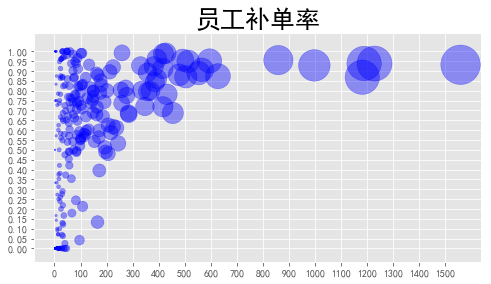

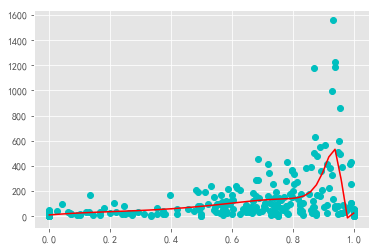

In [24]:
z=budan_rate()
my_bayes(z)

补单率（设计师错误）

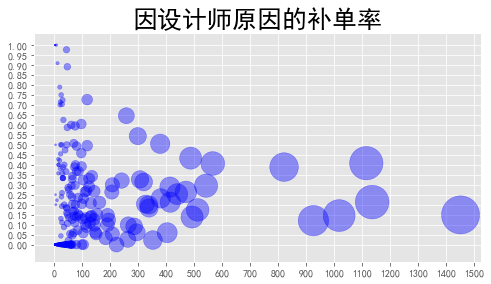

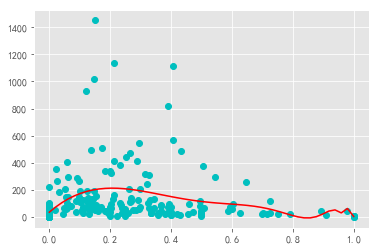

In [72]:
z=budan_rate(data=tmp_designer,my_x_ticks=np.arange(0, 1600, 100),savename="因设计师原因的补单率")
# z[z.columns[1]],z[z.columns[0]]=z[z.columns[0]],z[z.columns[1]]
my_bayes(z)

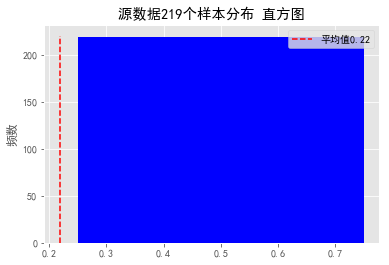

95.0% Confidence Interval: ( 0.19, 0.25)


In [73]:
A=ci_t(z['补单率'],0.95)

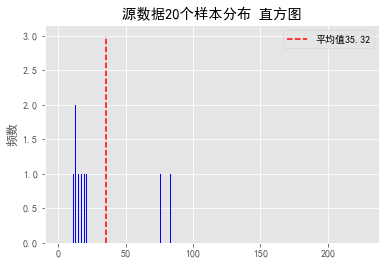

95.0% Confidence Interval: ( 11.53, 59.11)


In [75]:
B=ci_t(z['建单数量'][(z['补单率']>A[0])&(z['补单率']<A[1])]/5,0.95)
dingdan_num=(z['建单数量'][(z['补单率']>A[0])&(z['补单率']<A[1])]).describe()

* 因设计师原因的错误在35%大致可以算是现阶段较为成熟的设计师。
* 设计师大概要处理11-59个合同左右的订单可以达到这个水平(90-140)

<div class="burk">
需要花费一个门店培养时间为n？？</div><i class="fa fa-lightbulb-o "></i>

In [6]:
B=[8.18,66.99]

In [76]:
#取得大于最小值的数字的店
df_dingdan['订单数量']=1
tmp=df_dingdan[['流水号','建单日期','订单数量','门店名称','下单员工']]
tmp=tmp.groupby(['下单员工','流水号','门店名称']).aggregate({'订单数量':sum}).reset_index()[['流水号','下单员工','门店名称']]
tmp['流水数量']=1
tmp=tmp.groupby(['下单员工','流水号','门店名称']).aggregate({'流水数量':sum}).reset_index()[['流水号','下单员工','流水数量','门店名称']]
# tmp=tmp.groupby(['下单员工','流水号','门店名称']).aggregate({'流水数量':sum})
tmp=tmp.groupby(['下单员工']).aggregate({'流水数量':sum}).reset_index()[['下单员工','流水数量']]
tmp=tmp[(tmp['流水数量']>B[0])]
yuangong_list=tmp['下单员工'].tolist()
yuangong_list[0:2]

#按每个店的下单时间排序订单，取1-9,1-66时间间隔
#前n个订单的补单率，总补单率关系

['代晨迪', '仲美花']

In [83]:
df_tmp=pd.DataFrame(columns=['下单员工', '流水数量', '建单日期', '建单日期1'])#空表
for i in range(0,len(yuangong_list)):
    df_dingdan['建单日期1']=df_dingdan['建单日期']
    tmp=df_dingdan[df_dingdan['下单员工']==yuangong_list[i]].sort_values(["建单日期"]).groupby(['流水号','下单员工']).aggregate({'建单日期':min,'建单日期1':max}).reset_index()[['流水号','下单员工','建单日期','建单日期1']]
    if len(tmp)>=B[0]:
        tmp=tmp[:59]
        tmp['流水数量']=len(tmp)
        df_tmp=df_tmp.append(tmp.groupby(['下单员工','流水数量']).aggregate({'建单日期':min,'建单日期1':max}).reset_index().loc[0],ignore_index=True)
    else:
        continue
# ['流水数量'：]


5

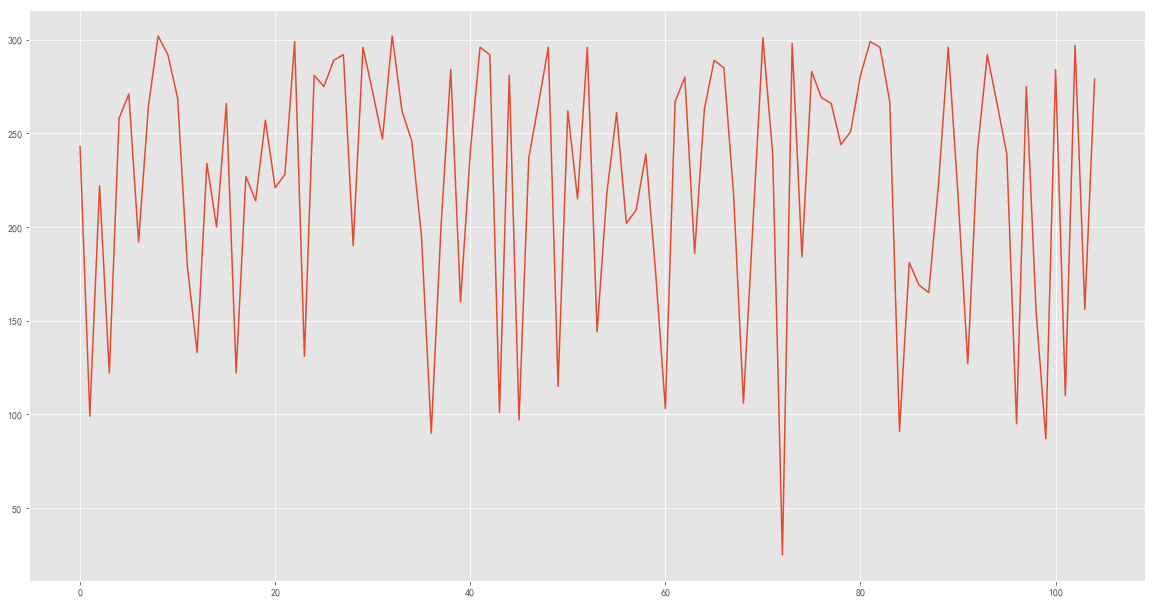

In [84]:
df_tmp["持续时间"]=(pd.to_datetime(df_tmp['建单日期1'])-pd.to_datetime(df_tmp['建单日期'])).dt.days.dropna().astype(int)
df_tmp["持续时间"].plot()
fig = plt.gcf()
fig.set_size_inches(20,10.5)
fig.savefig("到达59个订单的时间.png",dpi=100)

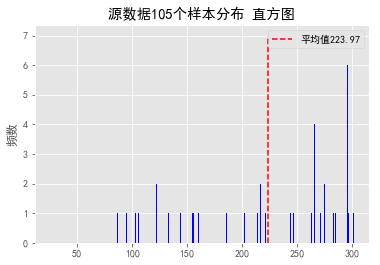

95.0% Confidence Interval: ( 211.08, 236.86)


(211.07874257302973, 236.8641145698274)

In [85]:
ci_t(df_tmp["持续时间"],0.95)

结论：设计师完成11个订单的时间大概在4个月-5个月,完成59个订单的时间大概在7-8个月。

## 结论

- 总体补单率在订单数量上升后会有上升趋势
- 每一个合同的补单率均值在42.3%。补单率中值在44.7%，说明大部分合同的补单率会在42.3%之下。订单几乎有一半的补单率。而且近一年补单率并没有很大程度上的改变。下一步需要查看订单补单的原因具体哪些是工厂的原因，哪些是门店的原因，哪些是客户新增的需要进一步判断
- 现阶段优秀的设计师在4-5个月的时候因设计出错补单率会下降到35%，资质较差的设计师在7-8个月也会下降到35%左右

补单率（客户新增
）

In [ ]:
# z[z.columns[1]],z[z.columns[0]]=z[z.columns[0]],z[z.columns[1]]
my_bayes(df_tmp)

C:\Users\d\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: RankWarning: Polyfit may be poorly conditioned
  This is separate from the ipykernel package so we can avoid doing imports until


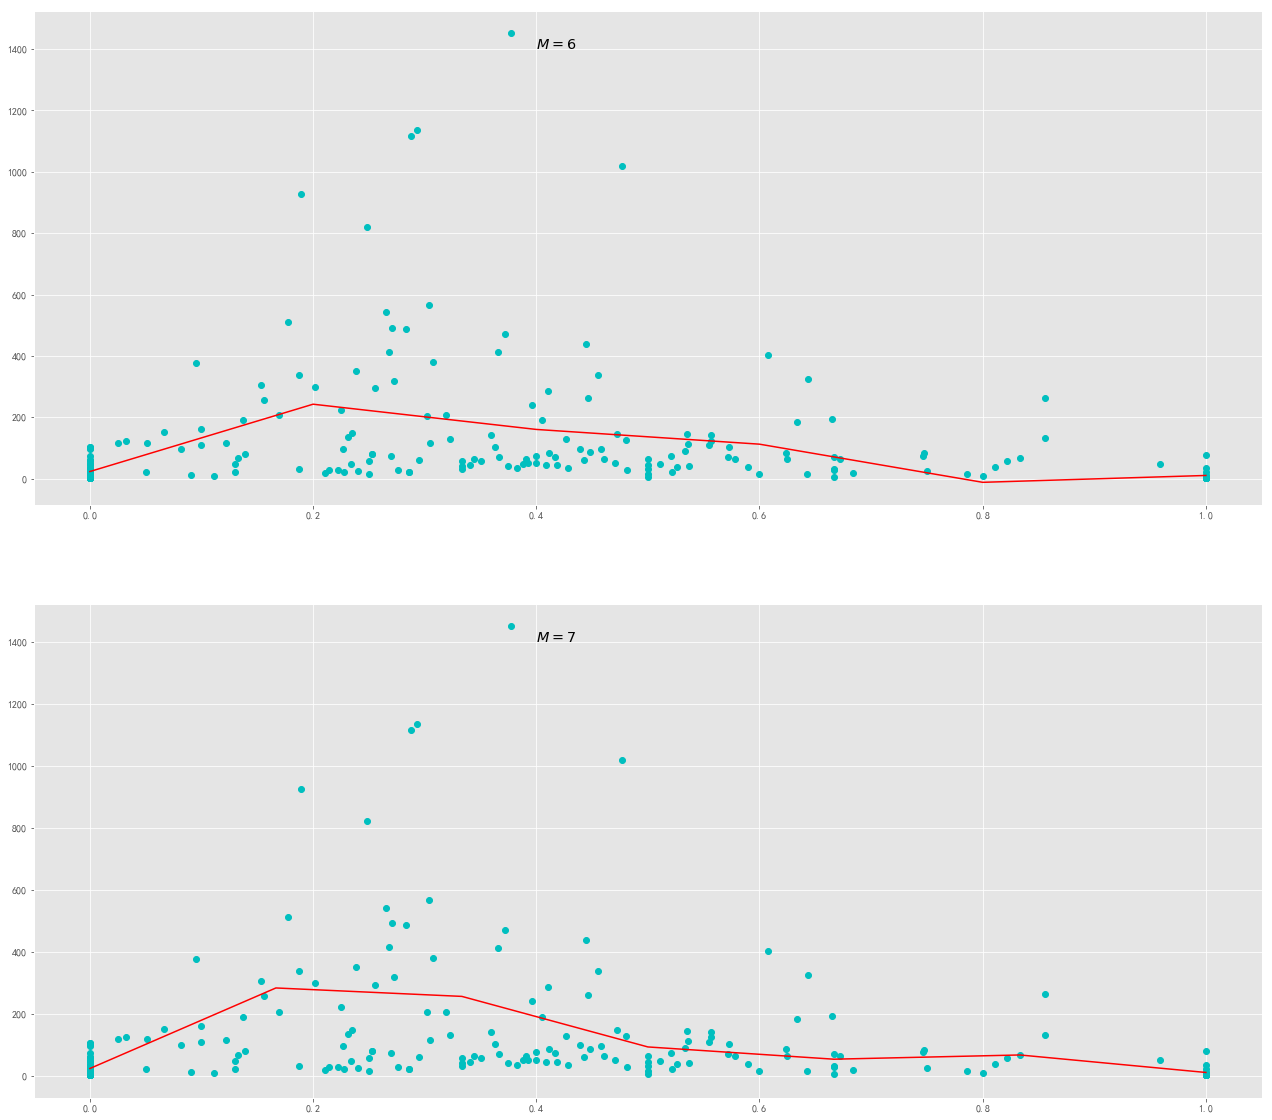

In [21]:
coeff=0
x_tr,t_tr=z[u'补单率'].as_matrix(),z[u'建单数量'].as_matrix()
coeff = np.polyfit(x_tr, t_tr, len(z))
f = np.poly1d(coeff)
fig, axes = plt.subplots(2,1, figsize=(22, 20))
axes = axes.flatten()  
len(axes)
a=6
for ax,i in zip(axes,range(a,len(axes)+a)):
    xx = np.linspace(0, 1, i)
    ax.plot(x_tr,t_tr,'co')
    ax.plot(xx, f(xx), 'r')
    ax.text(0.4, 1400, '$M={}$'.format(i), fontsize="x-large")

In [13]:
#动态效果
pie = Pie()
pie.add('补单原因', BBB,AAA,is_label_show=True,  legend_pos='left')
pie.render('data/补单原因.html')

In [131]:
df_budan.head()

,流水号,补单建单人,补单建单时间-T,补单号,订单号,补单原因,补单数量
53,10004340,陈志伟,6/25/2018 09:01:19,7330600021806250001,1.330600e+18,"软件错误,圆方软件错误,其他",1.0
54,10004455,周兵,6/24/2018 19:52:58,7320500041806240051,1.320500e+18,"客户新增,其他,其他",0.0
55,10004455,周兵,6/24/2018 19:40:24,7320500041806240001,1.320500e+18,"客户新增,其他,其他",0.0
56,10003570,王凤英,6/24/2018 18:23:01,7130100011806240002,1.130100e+18,"物料问题,其他,其他",1.0
57,10003570,王凤英,6/24/2018 18:18:36,7130100011806240001,1.130100e+18,"生产错误,封边错误,封边质量问题",1.0


# 问题反馈

## 问题分类占比

In [50]:
df_temp=pd.DataFrame(columns=['客户新增','设计师错误','生产错误','运输出错','订单处理错误','软件错误','安装错误','物料问题','仓库错误','采购错误'])
a=df_temp.columns[0]
df_tmp=df_budan.dropna(subset=['补单原因'])
dict_tmp={}
dict_tmp[a]=df_tmp["补单原因"].apply(lambda x: 1 if a in x else 0).sum()
dict_tmp

{'客户新增': 1330}

In [51]:
df_temp=pd.DataFrame(columns=['客户新增','设计师错误','生产错误','运输出错','订单处理错误','软件错误','安装错误','物料问题','仓库错误','采购错误'])#空表
# def budan_classifier(reason):
dict_tmp={}
df_tmp=df_budan.dropna(subset=['补单原因'])
for i in range(0,len(df_temp.columns)): 
    a=df_temp.columns[i]
    dict_tmp[a]= df_tmp["补单原因"].apply(lambda x: 1 if a in x else 0).sum()
pd.DataFrame([dict_tmp]).values[0].sum()#补单原因4654个

# len(df_budan) #总补单数4241


# df_tmp['设计师错误']



4654

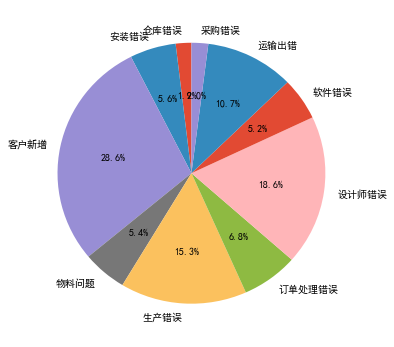

In [52]:
AAA=pd.DataFrame([dict_tmp]).T[0].tolist()
BBB=pd.DataFrame([dict_tmp]).T.index.tolist()
patches,l_text,p_text=plt.pie(AAA,labels=BBB,labeldistance = 1.1,autopct = '%3.1f%%',startangle = 90,pctdistance = 0.6)
fig = plt.gcf()
fig.set_size_inches(6,6)
fig.savefig("订单问题占比.png",dpi=100)


In [163]:
[i / 16.07 for i in [4.99,
7.29,
2.63,
1.16,]]

[0.3105164903546982,
 0.4536403235843186,
 0.16365899191039202,
 0.07218419415059116]

## 取得反馈数据

问题反馈均有填写，问题反馈在待受理，建单中，受理退回，受理中，已发货。均不会有补单原因

Building prefix dict from the default dictionary ...
DEBUG:jieba:Building prefix dict from the default dictionary ...
Loading model from cache C:\Users\d\AppData\Local\Temp\jieba.cache
DEBUG:jieba:Loading model from cache C:\Users\d\AppData\Local\Temp\jieba.cache
Loading model cost 0.904 seconds.
DEBUG:jieba:Loading model cost 0.904 seconds.
Prefix dict has been built succesfully.
DEBUG:jieba:Prefix dict has been built succesfully.


16

In [120]:
len(df_budan)

4294

In [5]:
df_budan=pd.read_excel('budan2018-06-26.xls')
feed_back=df_budan[['问题反馈','补单原因','补单建单时间']]
feed_back=feed_back.dropna(subset=['补单原因'])
feed_back['补单原因-s']=[i.split(",")[0] for i in feed_back['补单原因']]
budan_reason=feed_back.drop_duplicates('补单原因-s')["补单原因-s"]

In [124]:
feed_back.drop(['补单原因'],axis=1).head()

,问题反馈,补单建单时间,补单原因-s
18,鞋柜。设计师漏下,2018-06-25,设计师错误
19,补铰链，,2018-06-25,客户新增
22,1块板件,2018-06-25,客户新增
24,4个小封板,2018-06-25,客户新增
25,门板高度小了2mm，门缝无法调整齐平。,2018-06-25,软件错误


In [163]:
feed_back['补单建单时间']=pd.to_datetime(feed_back['补单建单时间'])
# feed_back['补单建单时间']
# feed_back.groupby([pd.Grouper(key="补单建单时间",freq='1w')])["补单原因-s"]
fanwei=pd.date_range(feed_back['补单建单时间'].iloc[-1],feed_back['补单建单时间'].iloc[1],freq='15D')
pd.cut(feed_back,fanwei,right=False)


TypeError: Cannot cast ufunc less input from dtype('<m8[ns]') to dtype('<m8') with casting rule 'same_kind'

In [110]:
df_budan.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4294 entries, 0 to 4293
Data columns (total 23 columns):
编号        4294 non-null int64
客户姓名      4294 non-null object
流水号       4294 non-null int64
补单号       4294 non-null int64
品牌        4294 non-null object
产品信息      4294 non-null object
产品类型      4294 non-null object
门店名称      4294 non-null object
门店类型      4294 non-null object
补单建单人     4294 non-null object
补单建单时间    4294 non-null object
发货时间      3785 non-null object
补单原因      4236 non-null object
问题反馈      4294 non-null object
排产日期      4130 non-null object
补单状态      4294 non-null object
收款状态      4294 non-null object
收款日期      4164 non-null object
结算价       4294 non-null float64
折后价       4197 non-null float64
折扣备注      1045 non-null object
零售价       4294 non-null float64
出厂价       0 non-null float64
dtypes: float64(4), int64(3), object(16)
memory usage: 771.7+ KB


In [113]:
feed_back['补单原因-s'].value_counts()

客户新增      1299
设计师错误      789
生产错误       594
运输出错       437
订单处理错误     273
软件错误       232
安装错误       228
物料问题       226
仓库错误        79
采购错误        79
Name: 补单原因-s, dtype: int64

In [118]:
#新建目录
import os
for i in feed_back.drop_duplicates('补单原因-s')["补单原因-s"]:
    folder = os.getcwd() + '\\vector space model\\'+i+'//'
    if not os.path.exists(folder):
        os.makedirs(folder)



In [7]:
# df_budan
feed_back.head()
a=range(0,len(feed_back))
       # 以追加的方式
for i,j in zip(a,feed_back['问题反馈']):
    f=open("origin data//"+feed_back["补单原因-s"].iloc[i]+"//feedback"+str(i)+".txt","w")
    f.write(j)
    f.write("\n")
    f.close()
print("done!")

done!


## 整理数据

### 去除停用词

In [13]:

#!/usr/bin/env python
# coding=utf-8

import sys,os
reload(sys)
#sys.setdefaultencoding( "utf-8" )

import numpy as np
from numpy import *
import jieba
import math
import jieba.analyse
#jieba.load_userdict("stop_words.txt")
def read_from_file(file_name):
    with open(file_name,"r") as fp:
        words = fp.read()
    fp.close()
    return words
def stop_words(stop_word_file):
    words = read_from_file(stop_word_file)
    
    result = jieba.cut(words,cut_all=True)
    new_words = []
    for r in result:
        new_words.append(r)
    return set(new_words)
def del_stop_words(words,stop_words_set):
#   words是已经切词但是没有去除停用词的文档。
#   返回的会是去除停用词后的文档
    result = jieba.cut(words)
    new_words = []
    for r in result:
        if r not in stop_words_set:
            new_words.append(r)
    return new_words
for i,content in zip(a,feed_back['问题反馈']):
    for j in del_stop_words(content,stop_words('stop_words.txt')):
#         f=open("vector space model/feedback"+str(i)+".txt","a+")
        f=open("vector space model//"+feed_back["补单原因-s"].iloc[i]+"//feedback"+str(i)+".txt","a+")
        f.write(j)
        f.write("\n")
        f.close()
print("done!")
# def gen_sim(A,B):
#     num = float(np.dot(A,B.T))
#     denum = np.linalg.norm(A) * np.linalg.norm(B)
#     if denum == 0:
#         denum = 1
#     cosn = num / denum
#     sim = 0.5 + 0.5 * cosn
#     return sim 


done!


## 构建向量空间

In [385]:
def get_all_vector(file_path,stop_words_set):
    names = [ os.path.join(file_path,f) for f in os.listdir(file_path) ]
    posts = [ open(name).read() for name in names ]
    docs = []
    word_set = set()
    for post in posts:
        doc = del_stop_words(post,stop_words_set)
        docs.append(doc)
        word_set |= set(doc)
#         print(len(doc),len(word_set))

    word_set = list(word_set)
    docs_vsm = []
    #for word in word_set[:30]:
        #print word.encode("utf-8"),
    for doc in docs:
        temp_vector = []
        for word in word_set:
            temp_vector.append(doc.count(word) * 1.0)
        #print temp_vector[-30:-1]
        docs_vsm.append(temp_vector)

    docs_matrix = np.array(docs_vsm)
    column_sum = [ float(len(np.nonzero(docs_matrix[:,i])[0])) for i in range(docs_matrix.shape[1]) ]
    column_sum = np.array(column_sum)
    column_sum = docs_matrix.shape[0] / column_sum
    idf =  np.log(column_sum)
    idf =  np.diag(idf)
#     请仔细想想，根绝IDF的定义，计算词的IDF并不依赖于某个文档，所以我们提前计算好。
#     注意一下计算都是矩阵运算，不是单个变量的运算。
    for doc_v in docs_matrix:
        if doc_v.sum() ==0:
            doc_v = doc_v / 1
        else:
            doc_v = doc_v / (doc_v.sum())
        tfidf = np.dot(docs_matrix,idf)
        return names,tfidf
def tfidf(term,doc,word_dict,docset):
    tf = float(doc.count(term)) / (len(doc) + 0.001)
    idf = math.log(float(len(docset)) / word_dict[term])
    return tf * idf
def idf(term,word_dict,docset):
    idf = math.log(float(len(docset)) / word_dict[term])
    return idf

def word_in_docs(word_set,docs):
    word_dict = {}
    for word in word_set:
        #print word.encode("utf-8")
        word_dict[word] = len([doc for doc in docs if word in doc])
        #print word_dict[word],
    return word_dict
def randCent(dataSet, k):
    n = shape(dataSet)[1]
    centroids = mat(zeros((k,n)))#create centroid mat
    for j in range(n):#create random cluster centers, within bounds of each dimension
        minJ = min(dataSet[:,j]) 
        rangeJ = float(max(dataSet[:,j]) - minJ)
        centroids[:,j] = mat(minJ + rangeJ * random.rand(k,1))
    return centroids
    
def kMeans(dataSet, k, distMeas=gen_sim, createCent=randCent):
    m = shape(dataSet)[0]
    clusterAssment = mat(zeros((m,2)))#create mat to assign data points 
                                      #to a centroid, also holds SE of each point
    centroids = createCent(dataSet, k)
    clusterChanged = True
    counter = 0
    while counter <= 50:
        counter += 1
        clusterChanged = False
        for i in range(m):#for each data point assign it to the closest centroid
            minDist = inf; 
            minIndex = -1
            for j in range(k):
                distJI = distMeas(centroids[j,:],dataSet[i,:])
                if distJI < minDist:
                    minDist = distJI; 
                    minIndex = j
            if clusterAssment[i,0] != minIndex: 
                clusterChanged = True
            clusterAssment[i,:] = minIndex,minDist**2
        #print centroids
        for cent in range(k):#recalculate centroids
            ptsInClust = dataSet[nonzero(clusterAssment[:,0].A==cent)[0]]#get all the point in this cluster
            centroids[cent,:] = mean(ptsInClust, axis=0) #assign centroid to mean 
    return centroids, clusterAssment

## 将单词出现的次数转化为权值（TF-IDF）

IDF，可以由总文件数目除以包含该词语之文件的数目，再将得到的商取对数得到：
$$idf(t,D)=log(\frac{N}{|d∈D,t∈d|})$$

In [ ]:
# # -*- coding: utf-8 -*-
# import scipy as sp
# import numpy as np
# from sklearn.datasets import load_files
# from sklearn.cross_validation import train_test_split
# from sklearn.feature_extraction.text import  TfidfVectorizer
 
# '''加载数据集，切分数据集80%训练，20%测试'''
# movie_reviews = load_files('endata')  
# doc_terms_train, doc_terms_test, y_train, y_test\
#     = train_test_split(movie_reviews.data, movie_reviews.target, test_size = 0.3)
    
# '''BOOL型特征下的向量空间模型，注意，测试样本调用的是transform接口'''
# count_vec = TfidfVectorizer(binary = False, decode_error = 'ignore',\
#                             stop_words = 'english')
# x_train = count_vec.fit_transform(doc_terms_train)
# x_test  = count_vec.transform(doc_terms_test)
# x       = count_vec.transform(movie_reviews.data)
# y       = movie_reviews.target
# print(doc_terms_train)
# print(count_vec.get_feature_names())
# print(x_train.toarray())
# print(movie_reviews.target)


In [377]:
# get_all_vector("vector space model",'stop_words.txt')

In [388]:
# if __name__ == "__main__":
#     stop_words = stop_words("stop_words.txt")
#     names,tfidf_mat = get_all_vector("./vector space model/",stop_words)
#     myCentroids,clustAssing = kMeans(tfidf_mat, 3, gen_sim, randCent)
#     for label,name in zip(clustAssing[:,0],names):
#         print(label,name)

In [43]:
file_name = "del_stop_words.txt"
def topK(file_name):
    f=open(file_name, "rb")
    content = f.read()
    tags = jieba.analyse.extract_tags(content, topK=20,withWeight=False,allowPOS=('ns', 'n', 'vn', 'v')) 
    f.close()
    # print("/".join(tags))  
    return tags

In [320]:
content[:11]

'桌面\n工厂\n桌面\n模型'

In [3]:
def read_from_file(file_name):
    with open(file_name,"r") as fp:
        words = fp.read()
    fp.close()
    return words
def stop_words(stop_word_file):
    words = read_from_file(stop_word_file)
    
    result = jieba.cut(words,cut_all=True)
    new_words = []
    for r in result:
        new_words.append(r)
    return set(new_words)
def del_stop_words(words,stop_words_set):
#   words是已经切词但是没有去除停用词的文档。
#   返回的会是去除停用词后的文档
    result = jieba.cut(words)
    new_words = []
    for r in result:
        if r not in stop_words_set:
            new_words.append(r)
    return new_words

def MergeTxt(filepath,outfile):
    k = open(filepath+outfile, 'a+')
    for parent, dirnames, filenames in os.walk(filepath):
        for filepath in filenames:
            txtPath = os.path.join(parent, filepath)  # txtpath就是所有文件夹的路径
            f = open(txtPath)
            ##########换行写入##################
            k.write(f.read()+"\n")

    k.close()

    print("finished")


In [20]:
import os
path='origin data/'
for i in os.walk(path):
    for j in i[-1]:
         MergeTxt(j,'result.txt')
    break

finished
finished
finished
finished
finished
finished
finished
finished
finished
finished


In [ ]:
门板
尺寸
封板
错误
层板
出错
设计
柜子
设计师
抽屉
下单
柜体
面板
背板
漏下
拉手
吊柜
台面
需要
抽面

In [44]:
A=[]
path='origin data/'
for j in i[-1]:
    A.append(j)
    A.append(topK(path+j))
A

['仓库错误result.txt',
 ['拉手',
  '铰链',
  '发错',
  '工厂',
  '层板',
  '门板',
  '发货',
  '榻榻米',
  '布兰',
  '尺寸',
  '底座',
  '单子',
  '抽屉',
  '颜色',
  '没配',
  '接长',
  '灯线',
  '补单',
  '侧板',
  '型号'],
 '安装错误result.txt',
 ['安装',
  '破损',
  '损坏',
  '门板',
  '封板',
  '错误',
  '顶线',
  '层板',
  '抽屉',
  '台面',
  '拉手',
  '抽面',
  '现场',
  '面板',
  '补单',
  '运输',
  '导轨',
  '收口',
  '原因',
  '背板'],
 '客户新增result.txt',
 ['客户',
  '新增',
  '门板',
  '拉手',
  '封板',
  '层板',
  '尺寸',
  '原因',
  '补单',
  '铰链',
  '增加',
  '要求',
  '抽屉',
  '收口',
  '工厂',
  '柜子',
  '背板',
  '面板',
  '需要',
  '移门'],
 '物料问题result.txt',
 ['门板',
  '顶线',
  '变形',
  '破损',
  '爆边',
  '移门',
  '问题',
  '抽面',
  '完电',
  '电冲',
  '瑕疵',
  '拉手',
  '台面',
  '工厂',
  '原因',
  '抽屉',
  '导轨',
  '生锈',
  '损坏',
  '气泡'],
 '生产错误result.txt',
 ['门板',
  '工厂',
  '尺寸',
  '抽屉',
  '开槽',
  '铰链',
  '层板',
  '错误',
  '底板',
  '侧板',
  '背板',
  '开孔',
  '衣柜',
  '开错',
  '发错',
  '面板',
  '补单',
  '抽面',
  '吊柜',
  '生产'],
 '订单处理错误result.txt',
 ['门板',
  '尺寸',
  '抽屉',
  '层板',
  '错误',
  '背板',
  '工厂',
  '铰链',
  '拉手',
  '面板'

In [45]:
topK(path+'物流.txt')

['圣盟',
 '供应链',
 '物流',
 '通胜',
 '集团',
 '管理',
 '公司',
 '总部',
 '企业',
 '整车',
 '采购',
 '工作',
 '供应商',
 '客户',
 '罢工',
 '亚太区',
 '业务',
 '底特律',
 '员工',
 '蜘蛛']